<h1 style="line-height:1; margin:0 0 15px 0; text-align:center">
  Probabilistic Cross-Matching for HMXB Candidate Identification
</h1>
<p style="line-height:1.8; margin:0; font-weight:500; text-align:center">
  Mabel Peñaherrera
</p>
<p style="line-height:1.8; margin:0; text-align:center">
  Columbia University NuSTAR High-Energy Astrophysics Group
</p>
<p style="line-height:1.8; margin:0; text-align:center">
  July 2024
</p>

# Import libraries

In [8]:
# === Standard library ===
import math
import concurrent.futures  # parallelism for matching or heavy ops

# === Third-party ===
import numpy as np  # numerical arrays
import pandas as pd  # tabular manipulation
import matplotlib.pyplot as plt  # plotting
from matplotlib.patches import Ellipse  # annotated shapes
import matplotlib.ticker as ticker  # axis tick control

from astropy import units as u  # unit-safe calculations
from astropy.coordinates import SkyCoord  # sky coordinate handling
from astropy.table import Table, Column  # structured tables
from astropy.io import ascii  # reading legacy ASCII catalogs
from astropy.io import fits  # FITS file I/O

from astroquery.vizier import Vizier  # catalog queries

from sklearn.neighbors import KDTree  # spatial indexing for cross-matching

# === Plotting configuration ===
plt.rcParams["font.size"] = 12  # base font size
plt.rcParams["font.family"] = ["Times New Roman", "Times", "serif"]  # preferred font family fallback chain
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams.get("font.serif", [])
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # use DejaVu Serif for rendering math expressions
plt.rcParams["figure.dpi"] = 250  # improve visual quality

# Catalog ingestion and preparation  
Load and clean Muno, GALACTICNUCLEUS, and VVV catalogs; estimate central positions; and prepare for cross-matching.

## Muno Catalog  
Load RA/Dec, visualize spatial distribution, mark central region, and export simplified table.

In [3]:
# === Read in Muno catalog ===
muno_catalog = ascii.read("muno3.csv")  # expects 'RAJ2000' and 'DEJ2000' columns

# Print table
print(f"Number of entries: {len(muno_catalog)}")
muno_catalog[:5]  # print first 5 rows of the table

Number of entries: 9017


RAJ2000,DEJ2000,ePos,Band,Nobs,PSF,Flags,PKS,f_PKS,Sct.tot,l_Sct.net,Sct.net,Hct.tot,l_Hct.net,Hct.net,<E>,HR0,HR1,HR2,CXOGC
float64,float64,float64,str4,int64,float64,str5,float64,str1,int64,str1,float64,int64,str1,float64,float64,float64,float64,float64,str15
266.23813,-28.96121,1.8,soft,14,0.9,s,-4.5,--,86,--,59.7,185,<,-1.4,1.0,-1.0,--,--,174457.1-285740
266.23941,-28.93967,2.0,full,15,0.9,lb,-0.09,--,52,<,-1.0,357,--,58.2,4.6,--,1.0,-0.169,174457.4-285622
266.2462,-29.10122,1.3,full,12,0.87,sc,-2.57,--,118,--,29.9,498,--,148.9,3.5,0.116,0.299,-0.254,174459.1-290604
266.24982,-29.05683,2.0,full,23,0.9,g,-1.09,--,96,<,4.9,369,--,34.4,3.1,1.0,-1.0,--,174459.9-290324
266.24994,-29.09415,1.5,hard,18,0.9,b,-0.97,--,107,<,-8.0,550,--,115.1,4.8,--,1.0,-0.012,174459.9-290538


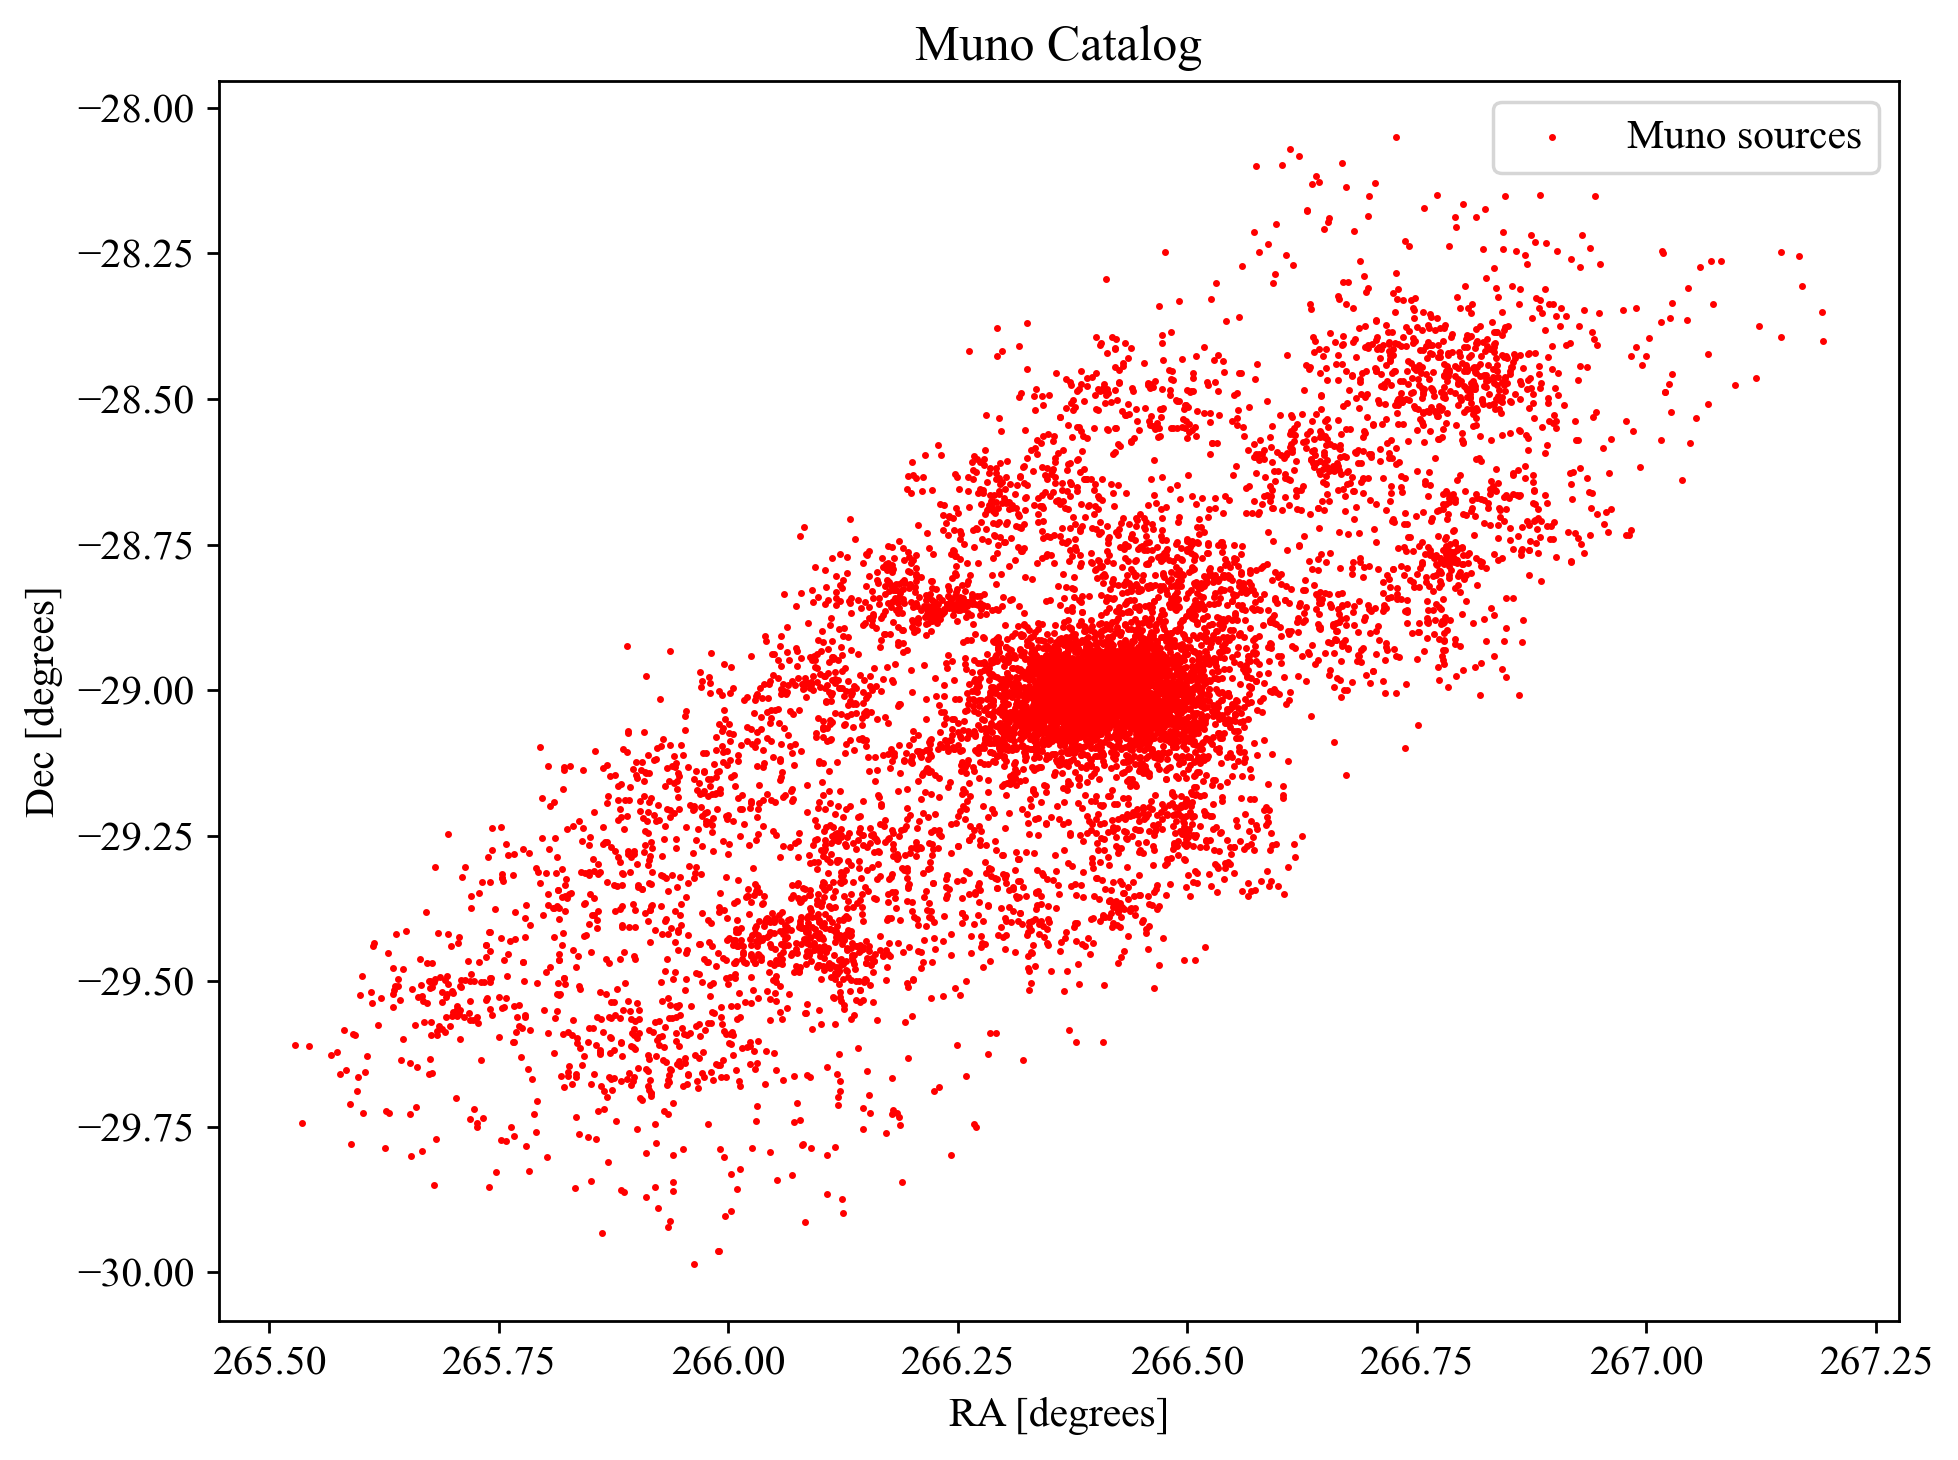

In [9]:
# === Prepare simplified RA/Dec table for cross-matching ===
muno_ra_deg = muno_catalog["RAJ2000"]
muno_dec_deg = muno_catalog["DEJ2000"]
muno_ra_dec_table = Table([muno_ra_deg, muno_dec_deg], names=("RAJ2000", "DEJ2000"))

# Save the new table as a .tsv file
ascii.write(muno_ra_dec_table, 'muno_ra_dec.tsv', format='tab', overwrite=True)

# Plot Muno catalog
plt.figure(figsize=(8, 6))
plt.scatter(muno_ra_deg, muno_dec_deg, color = 'red', s=1, label="Muno sources")
plt.xlabel("RA [degrees]")
plt.ylabel("Dec [degrees]")
plt.title("Muno Catalog")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# === Central coordinate computation ===

# Using the mean of RA/Dec as a heuristic central position
center_ra_muno = np.mean(muno_ra_deg)  # in degrees
center_dec_muno = np.mean(muno_dec_deg)  # in degrees

print(
    "Central Source Coordinates (mean RA, Dec) [deg]: "
    f"({center_ra_muno:.5f}, {center_dec_muno:.5f})"
)

Central Source Coordinates (mean RA, Dec) [deg]: (266.37263, -29.00502)


In [11]:
# === Export simplified catalog ===
ascii.write(
    muno_ra_dec_table,
    "muno.tsv",
    format="tab",
    overwrite=True,
)

## GALACTICNUCLEUS Catalog

This catalog is more complex as the data is distributed across multiple files that must be merged and cleaned. Likewise, several entries contain missing values that require handling in order to produce a unified, analysis-ready master catalog.

Preprocess data to generate a unified table, visualize spatial distribution, mark central region, and export simplified table.

In [12]:
# === Read in GALACTINUCLEUS catalog ===

# Data from central region, inner bulge north, inner bulge south, NSD east, NSD west, transition east & transition west
table1 = pd.read_csv('1.tsv', delimiter=';', low_memory=False)
table2 = pd.read_csv('2.tsv', delimiter=';', low_memory=False)
table3 = pd.read_csv('3.tsv', delimiter=';', low_memory=False)
table4 = pd.read_csv('4.tsv', delimiter=';', low_memory=False)
table5 = pd.read_csv('5.tsv', delimiter=';', low_memory=False)
table6 = pd.read_csv('6.tsv', delimiter=';', low_memory=False)
table7 = pd.read_csv('7.tsv', delimiter=';', low_memory=False)

# Extract columns from each table
columns_to_extract = ['RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000', 'Jmag', 'Hmag', 'Ksmag']
tables_with_selected_columns = []

for table in [table1, table2, table3, table4, table5, table6, table7]:
    selected_columns = table[columns_to_extract]
    tables_with_selected_columns.append(selected_columns)

# Combine the tables with selected columns vertically stacked on top of each other
gn_catalog = pd.concat(tables_with_selected_columns, ignore_index=True)

# Print table
print(f"Number of entries: {len(gn_catalog)}")
gn_catalog[:5]  # print first 5 rows of the table

Number of entries: 3277646


,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,Jmag,Hmag,Ksmag
0,266.46716,-28.967893,0.002594,0.003231,11.35489,10.66565,10.40880
1,266.46735,-28.967538,0.001946,0.002423,12.14799,11.72075,11.55570
2,266.47372,-28.977522,0.000649,0.000808,13.81349,12.69735,12.33960
3,266.47858,-28.963477,0.005837,0.007270,14.06349,13.52395,13.41070
4,266.47314,-28.966582,0.003243,0.004039,14.61249,13.84815,13.62090


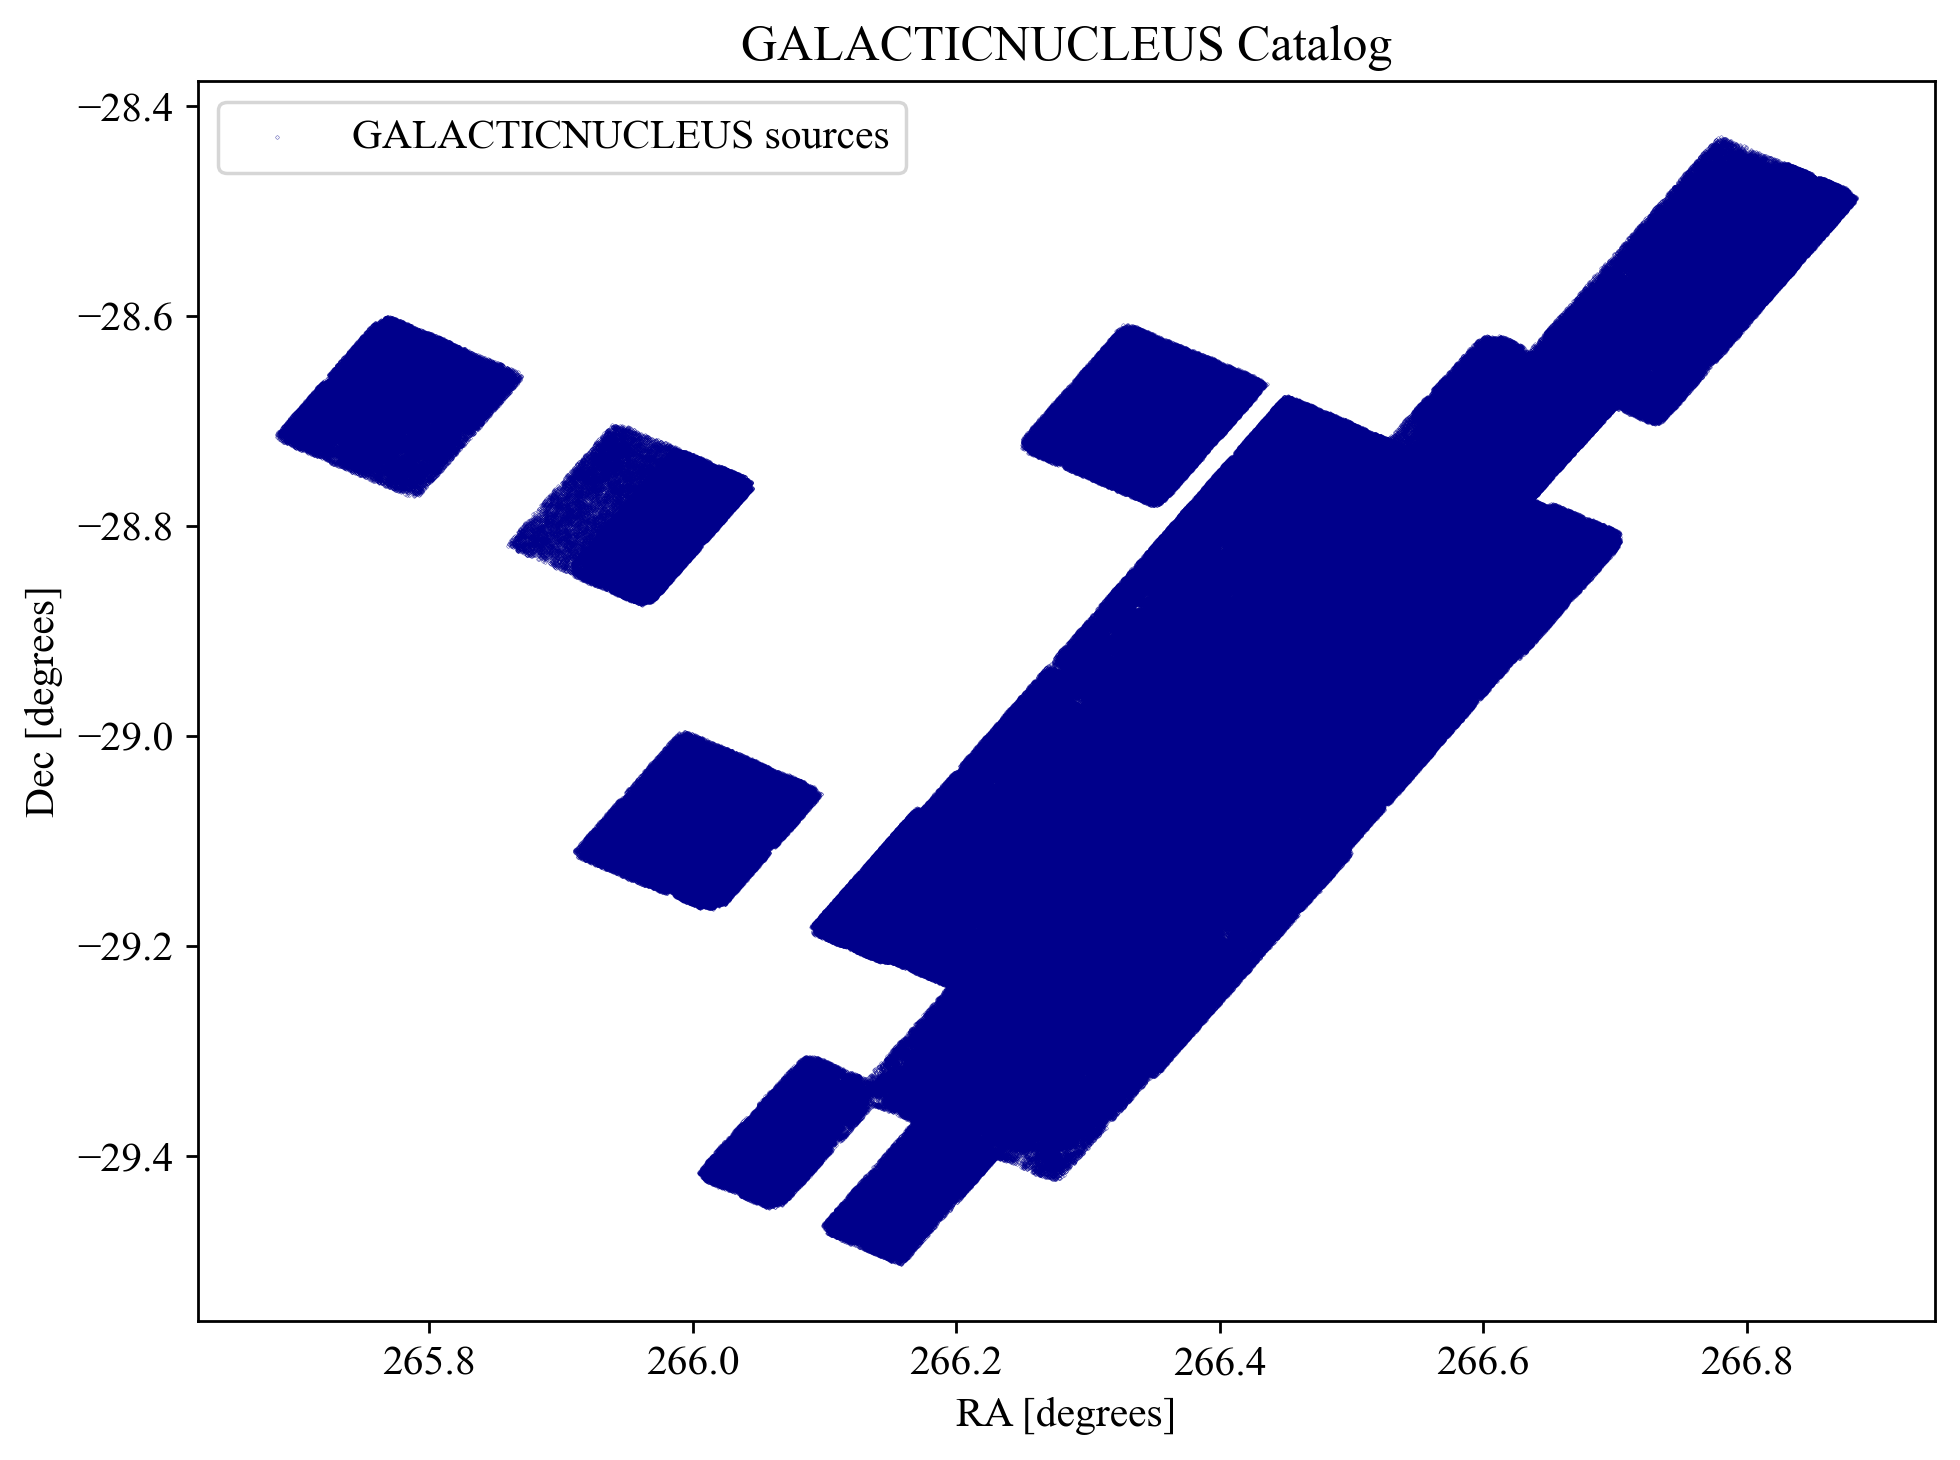

In [13]:
# === Convert empty values to null data ===
def to_number(n):
    try:
        n = float(n)
        return n
    except:
        return 0

gn_catalog['Ksmag'] = [to_number(n) for n in list(gn_catalog['Ksmag'])]
gn_catalog['Hmag'] = [to_number(n) for n in list(gn_catalog['Hmag'])]
gn_catalog['Jmag'] = [to_number(n) for n in list(gn_catalog['Jmag'])]

# === Prepare simplified RA/Dec table for cross-matching ===
gn_ra_deg = gn_catalog["RAJ2000"]
gn_dec_deg = gn_catalog["DEJ2000"]
gn_ra_dec_table = Table([gn_ra_deg, gn_dec_deg], names=("RAJ2000", "DEJ2000"))

# Plot GALACTICNUCLEUS catalog
plt.figure(figsize=(8, 6))
plt.scatter(gn_ra_deg, gn_dec_deg, color = 'darkblue', s=0.01, alpha=1, label="GALACTICNUCLEUS sources")
plt.xlabel("RA [degrees]")
plt.ylabel("Dec [degrees]")
plt.title("GALACTICNUCLEUS Catalog")
plt.grid(False)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [14]:
# === Central coordinate computation ===

# Using the mean of RA/Dec as a heuristic central position
center_ra_gn = np.mean(gn_ra_deg)  # in degrees
center_dec_gn = np.mean(gn_dec_deg)  # in degrees

print(
    "Central Source Coordinates (mean RA, Dec) [deg]: "
    f"({center_ra_gn:.5f}, {center_dec_gn:.5f})"
)

Central Source Coordinates (mean RA, Dec) [deg]: (266.36610, -28.93741)


In [15]:
# === Export simplified catalog ===
ascii.write(
    gn_ra_dec_table,
    "gn.tsv",
    format="tab",
    overwrite=True,
)

## VVV Catalog

The VVV catalog contains a large number of sources (8M), so we read and process the data in chunks (e.g., 1M rows at a time) to efficiently manage memory. As with the GALACTICNUCLEUS catalog, we combine separate data files into a single, unified table.

Preprocess data to generate a unified table, visualize spatial distribution, mark central region, and export simplified table.

In [16]:
# === Read in VVV catalog ===

chunk_size = 10 ** 6  # Adjust chunk size as needed
chunks = pd.read_csv('VVV_DR2_CDS.csv', chunksize=chunk_size, low_memory=False)

# Combine chunks into a single DataFrame
vvv_catalog = pd.concat(chunks, ignore_index=True)

# Print table
print(f"Number of entries: {len(vvv_catalog)}")
vvv_catalog[:5]  # print first 5 rows of the table

Number of entries: 8273053


,angDist,srcid,RAJ2000,DEJ2000,iauname,PriOrSec,mClass,Zmag3,e_Zmag3,Zperrbits,...,Sct.tot,l_Sct.net,Sct.net,Hct.tot,l_Hct.net,Hct.net,<E>,HR0,HR1,HR2
0,0.610573,515534548081,266.238126,-28.961040,VVV J174457.15-285739.74,0,-1,15.36,0.005,0,...,86,NaN,59.7,185,<,-1.4,1.0,-1.0,NaN,NaN
1,1.622606,515535962961,266.238414,-28.961586,VVV J174457.21-285741.71,0,-2,NaN,NaN,0,...,86,NaN,59.7,185,<,-1.4,1.0,-1.0,NaN,NaN
2,2.847024,515535947142,266.237442,-28.960697,VVV J174456.98-285738.50,0,-2,NaN,NaN,0,...,86,NaN,59.7,185,<,-1.4,1.0,-1.0,NaN,NaN
3,3.327779,515536138556,266.239129,-28.961510,VVV J174457.39-285741.43,0,-1,NaN,NaN,0,...,86,NaN,59.7,185,<,-1.4,1.0,-1.0,NaN,NaN
4,3.452001,515536093355,266.238905,-28.960532,VVV J174457.33-285737.91,0,1,NaN,NaN,0,...,86,NaN,59.7,185,<,-1.4,1.0,-1.0,NaN,NaN


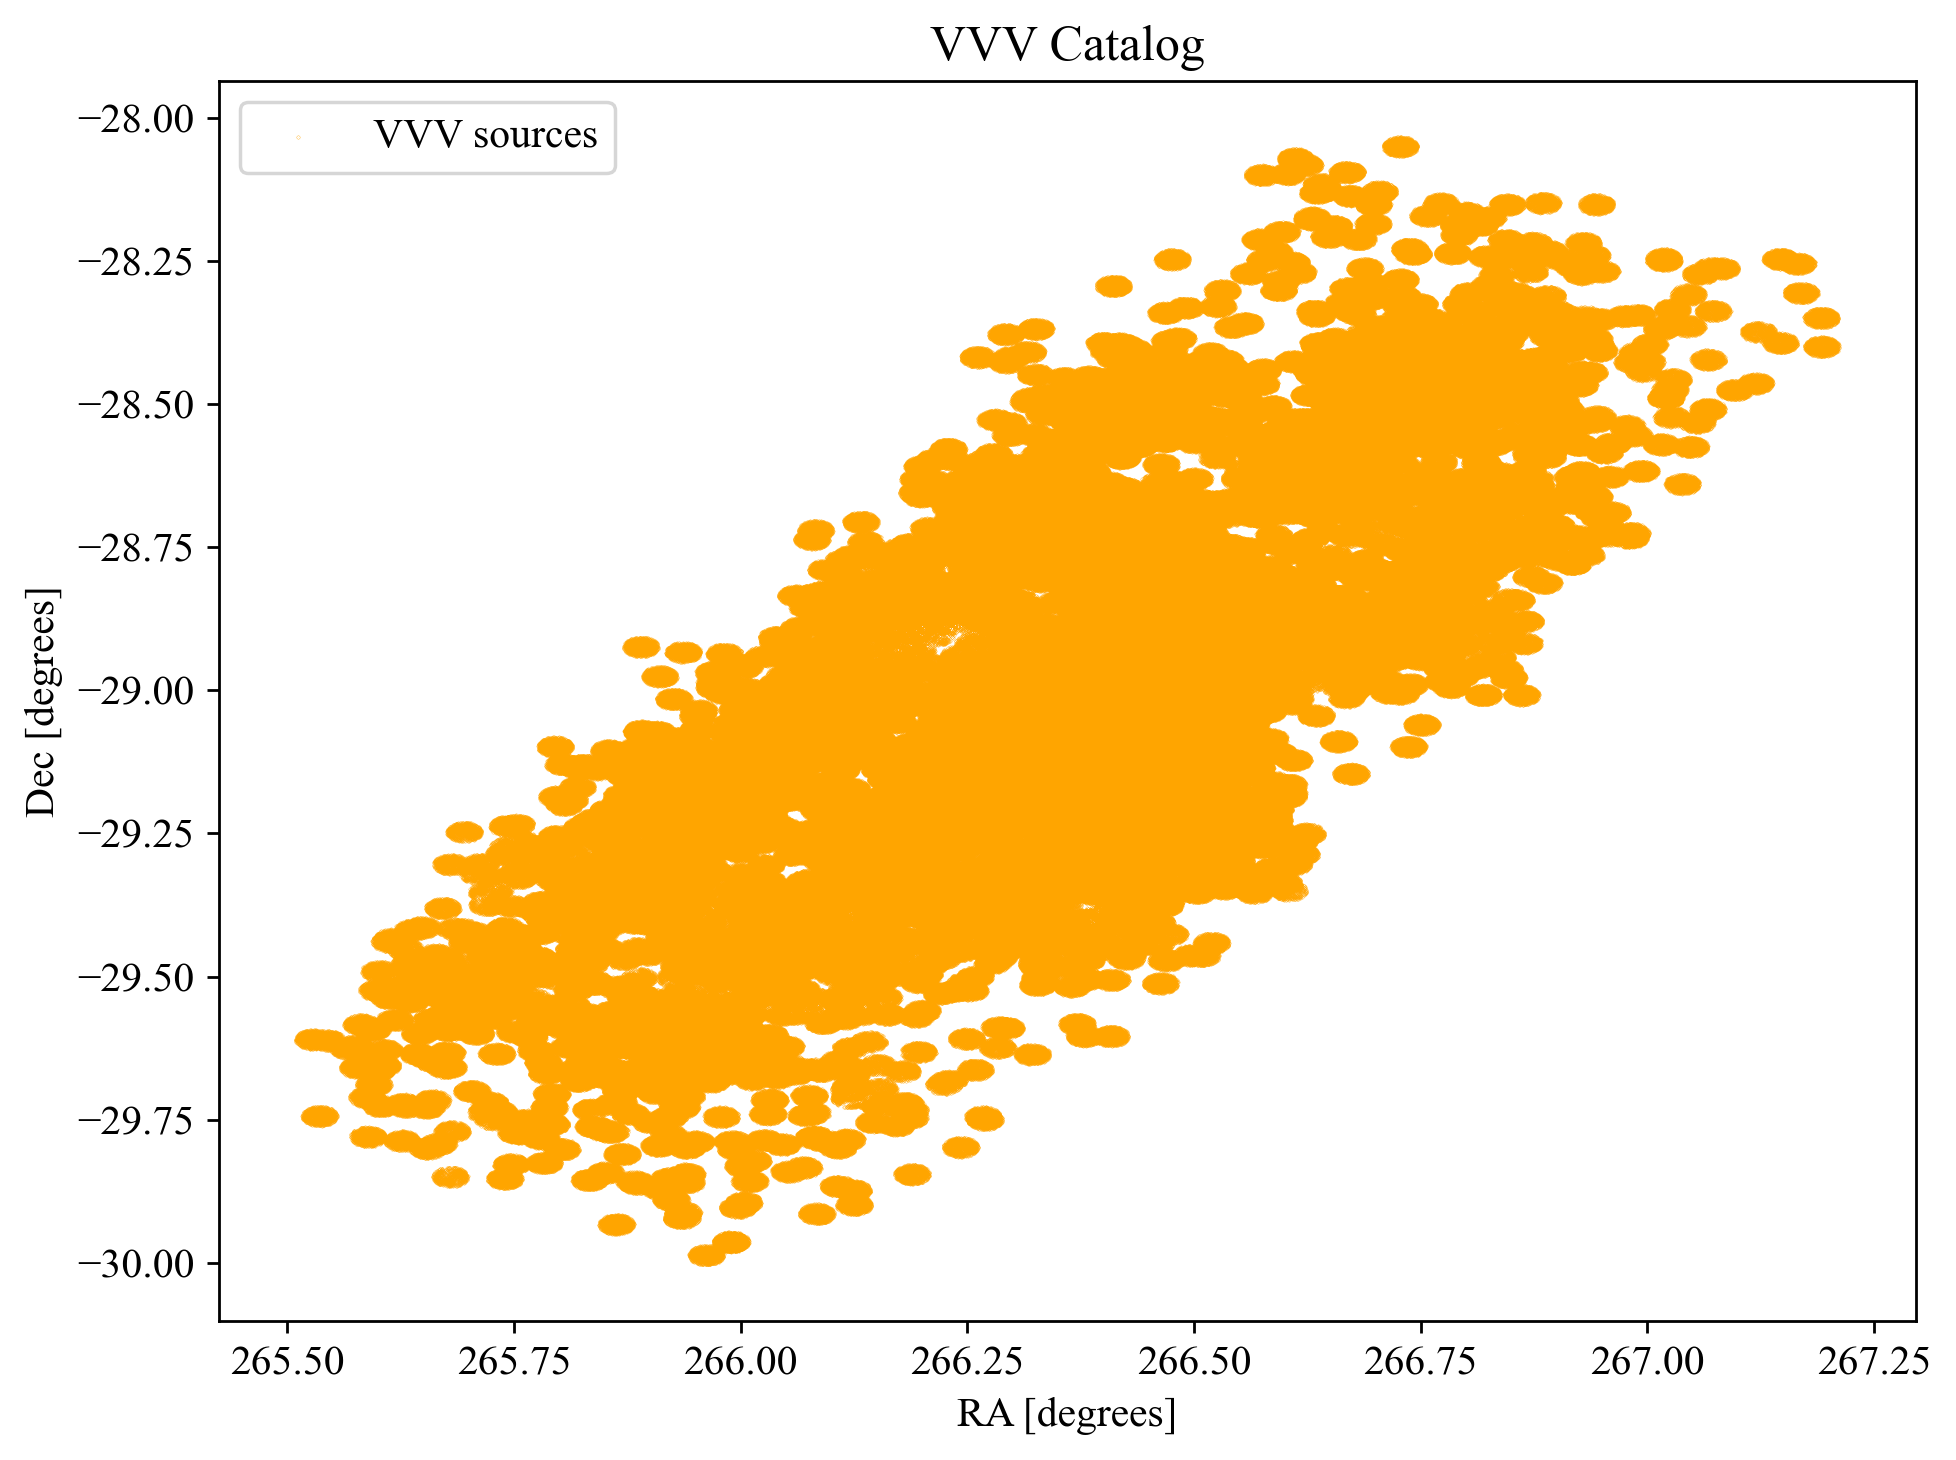

In [17]:
# === Convert empty values to null data ===
def to_number(n):
    try:
        n = float(n)
        return n
    except:
        return 0

vvv_catalog['Ksmag3'] = [to_number(n) for n in list(vvv_catalog['Ksmag3'])]
vvv_catalog['Hmag3'] = [to_number(n) for n in list(vvv_catalog['Hmag3'])]
vvv_catalog['Jmag3'] = [to_number(n) for n in list(vvv_catalog['Jmag3'])]

# === Prepare simplified RA/Dec table for cross-matching ===
vvv_ra_deg = vvv_catalog["RAJ2000"]
vvv_dec_deg = vvv_catalog["DEJ2000"]
vvv_ra_dec_table = Table([vvv_ra_deg, vvv_dec_deg], names=("RAJ2000", "DEJ2000"))

# Plot VVV catalog
plt.figure(figsize=(8, 6))
plt.scatter(vvv_ra_deg, vvv_dec_deg, color = 'orange', s=0.01, alpha=1, label="VVV sources")
plt.xlabel("RA [degrees]")
plt.ylabel("Dec [degrees]")
plt.title("VVV Catalog")
plt.grid(False)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [18]:
# === Central coordinate computation ===

# Using the mean of RA/Dec as a heuristic central position
center_ra_vvv = np.mean(vvv_ra_deg)  # in degrees
center_dec_vvv = np.mean(vvv_dec_deg)  # in degrees

print(
    "Central Source Coordinates (mean RA, Dec) [deg]: "
    f"({center_ra_vvv:.5f}, {center_dec_vvv:.5f})"
)

Central Source Coordinates (mean RA, Dec) [deg]: (266.37605, -29.00118)


In [19]:
# === Export simplified catalog ===
ascii.write(
    vvv_ra_dec_table,
    "vvv.tsv",
    format="tab",
    overwrite=True,
)

# Foreground source removal

We remove likely foreground contaminants from the primary catalogs before any cross-matching or candidate selection.

## Muno Catalog: HR0-based foreground removal

Foreground in the Muno X-ray catalog is identified via hardness ratio HR0.  
Based on the current heuristic, sources with HR0 in the window (-1.0, -0.175) are considered foreground and **excluded**. The remaining sources are retained for downstream analysis.

In [20]:
def remove_foreground_muno_by_hr0(muno_catalog, hr0_lower=-1.0, hr0_upper=-0.175):
    """
    Remove foreground sources from the Muno catalog using HR0.

    Parameters
    ----------
    muno_catalog : astropy.table.Table
        Original Muno catalog containing 'HR0'.
    hr0_lower : float
        Lower bound (exclusive) of HR0 for the foreground window.
    hr0_upper : float
        Upper bound (exclusive) of HR0 for the foreground window.

    Returns
    -------
    astropy.table.Table
        Filtered catalog with sources in the HR0 foreground window removed.
    """
    filtered = muno_catalog.copy()  # work on a copy to preserve original
    hr0 = filtered["HR0"]

    # Foreground defined as HR0 between hr0_lower and hr0_upper
    is_foreground = (hr0 > hr0_lower) & (hr0 < hr0_upper)

    # Keep everything that is not foreground
    keep_mask = ~is_foreground
    return filtered[keep_mask]

In [21]:
# Apply and report
tbl_muno_clean = remove_foreground_muno_by_hr0(muno_catalog)
print(f"Muno: kept {len(tbl_muno_clean)} / {len(muno_catalog)} sources after foreground removal")
tbl_muno_clean[:5].pprint()  # preview a few rows

Muno: kept 8288 / 9017 sources after foreground removal
 RAJ2000   DEJ2000  ePos Band Nobs ... <E>  HR0   HR1   HR2        CXOGC     
--------- --------- ---- ---- ---- ... --- ----- ----- ------ ---------------
266.23813 -28.96121  1.8 soft   14 ... 1.0  -1.0    --     -- 174457.1-285740
266.23941 -28.93967  2.0 full   15 ... 4.6    --   1.0 -0.169 174457.4-285622
 266.2462 -29.10122  1.3 full   12 ... 3.5 0.116 0.299 -0.254 174459.1-290604
266.24982 -29.05683  2.0 full   23 ... 3.1   1.0  -1.0     -- 174459.9-290324
266.24994 -29.09415  1.5 hard   18 ... 4.8    --   1.0 -0.012 174459.9-290538


## GALACTICNUCLEUS Catalog: Color-based foreground removal with missingness handling

Foreground/background separation for GN uses color cuts:
- Non-foreground (kept) criteria:  
  `J-H < 2.35`, `J-Ks < 3.0`, `H-Ks < 1.1`

Because some entries have missing magnitudes (J, H, Ks), we handle three cases:
1. **No missing values**: apply all three color cuts.
2. **Exactly one missing**: apply only cuts computable from available bands.
   - Missing J → use `H-Ks`
   - Missing H → use `J-Ks`
   - Missing Ks → use `J-H`
3. **Two or more missing**: ambiguous; do **not remove** but annotate for later review.

The function returns both the cleaned (kept) catalog and an annotated version with reason tags.

In [22]:
def remove_foreground_gn_with_missingness(gn_catalog, jh_thresh=2.35, jk_thresh=3.0, hk_thresh=1.1):
    """
    Remove foreground sources from GALACTICNUCLEUS, carefully handling missing J/H/Ks.

    Rules:
      - If all three magnitudes present: keep only if all non-foreground color cuts pass.
      - If exactly one is missing: keep if the available color (derived from the two present) passes its threshold.
      - If two or more missing: ambiguous, keep but tag so it can be revisited.

    Returns
    -------
    tbl_gn_clean : pandas.DataFrame
        Sources retained (non-foreground).
    tbl_gn_annotated : pandas.DataFrame
        Original with added columns:
          - 'foreground_removed' (bool): True if removed as foreground.
          - 'reason_kept' (str): explains why a source was kept or labeled 'foreground'.
    """
    tbl = gn_catalog.copy()

    # Compute colors; will be NaN if any input is missing
    tbl["J_H"] = tbl["Jmag"] - tbl["Hmag"]
    tbl["J_Ks"] = tbl["Jmag"] - tbl["Ksmag"]
    tbl["H_Ks"] = tbl["Hmag"] - tbl["Ksmag"]

    # Presence flags: treat zero as missing if that was how input cleaning encoded absence
    has_J = tbl["Jmag"].notna() & (tbl["Jmag"] != 0)
    has_H = tbl["Hmag"].notna() & (tbl["Hmag"] != 0)
    has_Ks = tbl["Ksmag"].notna() & (tbl["Ksmag"] != 0)

    # Case A: all present
    mask_all_present = has_J & has_H & has_Ks
    keep_all_present = (
        (tbl["J_H"] < jh_thresh)
        & (tbl["J_Ks"] < jk_thresh)
        & (tbl["H_Ks"] < hk_thresh)
    ) & mask_all_present

    # Case B: exactly one missing
    mask_missing_J = ~has_J & has_H & has_Ks        # J missing → use H_Ks
    keep_missing_J = (tbl["H_Ks"] < hk_thresh) & mask_missing_J

    mask_missing_H = has_J & ~has_H & has_Ks        # H missing → use J_Ks
    keep_missing_H = (tbl["J_Ks"] < jk_thresh) & mask_missing_H

    mask_missing_Ks = has_J & has_H & ~has_Ks       # Ks missing → use J_H
    keep_missing_Ks = (tbl["J_H"] < jh_thresh) & mask_missing_Ks

    # Case C: two or more missing → ambiguous, keep but mark
    mask_two_or_more_missing = (
        (~has_J & ~has_H & has_Ks)
        | (~has_J & has_H & ~has_Ks)
        | (has_J & ~has_H & ~has_Ks)
        | (~has_J & ~has_H & ~has_Ks)
    )
    keep_two_or_more_missing = mask_two_or_more_missing

    # Final keep (non-foreground) mask
    keep_mask = (
        keep_all_present
        | keep_missing_J
        | keep_missing_H
        | keep_missing_Ks
        | keep_two_or_more_missing
    )

    # Annotate for diagnostics
    tbl["foreground_removed"] = ~keep_mask
    tbl["reason_kept"] = np.select(
        [
            keep_all_present,
            keep_missing_J,
            keep_missing_H,
            keep_missing_Ks,
            keep_two_or_more_missing,
        ],
        [
            "all_colors_non_foreground",
            "missing_J_using_HKs",
            "missing_H_using_JKs",
            "missing_Ks_using_JH",
            "ambiguous_two_or_more_missing",
        ],
        default="foreground",
    )

    tbl_gn_clean = tbl[keep_mask].copy()
    return tbl_gn_clean, tbl

In [23]:
# Apply the GN foreground removal and report
tbl_gn_clean, tbl_gn_annotated = remove_foreground_gn_with_missingness(gn_catalog)

print(f"GN: kept {len(tbl_gn_clean)} / {len(gn_catalog)} sources after foreground removal")
print("Breakdown of kept sources by reason:")
print(tbl_gn_clean["reason_kept"].value_counts())

GN: kept 1836540 / 3277646 sources after foreground removal
Breakdown of kept sources by reason:
reason_kept
ambiguous_two_or_more_missing    1642991
all_colors_non_foreground         108396
missing_J_using_HKs                52017
missing_Ks_using_JH                22933
missing_H_using_JKs                10203
Name: count, dtype: int64


### Interpretation & Next Steps

- `reason_kept` categories:
  - `all_colors_non_foreground`: all three colors indicate non-foreground (strongest keep).
  - `missing_*`: only one band was missing; kept based on the remaining color.
  - `ambiguous_two_or_more_missing`: insufficient information to decide — retained conservatively.
  - `foreground`: filtered out as likely foreground.

- Kept the annotated DataFrame (`tbl_gn_annotated`) for:
  - Logging why each source survived.
  - Downstream filtering (e.g., revisit ambiguous sources).

# Cross-matching X-ray and infrared sources

We carry out two cross-matching experiments between the Muno X-ray catalog and the GALACTICNUCLEUS infrared catalog to separate real counterparts from chance alignments:

## 1. Strategy

- **No shift (real match):**  
  Use the astrometrically aligned catalogs directly. This includes both true physical counterparts and random coincidences.

- **Shifted (null/random trials):**  
  Apply a small random positional offset to the infrared catalog (or equivalently the X-ray catalog) in each trial. This preserves the source density and uncertainty structure while destroying true associations. Repeating this (e.g., 30 trials) builds up an empirical background distribution of matches expected by chance.

## 2. Match acceptance criterion

For each candidate pair we compute the angular separation $\phi$. A match is accepted if:

$$
\phi \le \sqrt{\sigma_{\mathrm{X}}^2 + \sigma_{\mathrm{IR}}^2}
$$

where:

- $\sigma_{\mathrm{X}}$ is the positional uncertainty of the X-ray source (from its `ePos`, in arcseconds),  
- $\sigma_{\mathrm{IR}}$ is the assumed (fixed) infrared positional uncertainty (e.g., $0.1''$),  
- The right-hand side is the **quadrature sum** of the two uncertainties.

This adaptive radius makes the matching significance-aware per source pair instead of relying on a fixed angular cutoff.

## 3. Magnitude binning

Accepted matches are binned by the infrared $K_s$ magnitude. We define uniform bins from 6.0 to 17.5 in 0.5-mag steps (e.g., `6.0–6.5`, `6.5–7.0`, ..., `17.0–17.5`) and count the number of matches in each bin.

## 4. Real vs. random comparison

Let $N_{\text{real}}(K_s)$ be the number of matches in a given $K_s$ bin from the unshifted (real) cross-match, and let $N_{\text{rand},i}(K_s)$ be the count from the $i$-th shifted (null) trial. Define:

- **Mean background per bin:**  
  $$
  \mu_{\text{rand}}(K_s) = \frac{1}{N_{\text{trials}}} \sum_{i=1}^{N_{\text{trials}}} N_{\text{rand},i}(K_s)
  $$
- **Background scatter (standard deviation):**  
  $$
  \sigma_{\text{rand}}(K_s) = \sqrt{\frac{1}{N_{\text{trials}}-1} \sum_{i=1}^{N_{\text{trials}}} \left(N_{\text{rand},i}(K_s) - \mu_{\text{rand}}(K_s)\right)^2}
  $$
- **Excess:**  
  $$
  \mathrm{Excess}(K_s) = N_{\text{real}}(K_s) - \mu_{\text{rand}}(K_s)
  $$
- **Significance:**  
  $$
  \mathrm{Significance}(K_s) = \frac{\mathrm{Excess}(K_s)}{\sigma_{\text{rand}}(K_s)}
  $$

This quantifies how many more matches are observed than expected by chance and with what statistical strength.

## 5. Reference

The approach follows Mauerhan et al. (2009): using shifted catalogs to empirically estimate random match rates and the quadrature sum of positional uncertainties to adaptively accept matches.

In [26]:
# === Define functions ===

import logging

# -----------------------------------------------------------------------------
# Logging: near the top of the module to control verbosity
# Example usage upstream: logging.basicConfig(level=logging.INFO)  # default hides DEBUG
logger = logging.getLogger(__name__)  # module-level logger

# -----------------------------------------------------------------------------
def make_skycoord_table(tbl, ra_col="RAJ2000", dec_col="DEJ2000"):
    """
    Build a SkyCoord from input catalog-like data, coercing RA/Dec to floats and
    dropping invalid rows. Returns (SkyCoord, valid_indices) where valid_indices
    are integer positions kept from the original table for alignment downstream.
    Accepts astropy Table-like (with .to_pandas), plain pandas DataFrame, or any
    mapping with RA/Dec columns.
    """
    if hasattr(tbl, "to_pandas"):  # Astropy Table path
        df = tbl.to_pandas()
    elif isinstance(tbl, pd.DataFrame):  # Already a DataFrame
        df = tbl.copy()
    else:  # Fallback: assume dict-like / structured with RA/Dec access
        df = pd.DataFrame({ra_col: tbl[ra_col], dec_col: tbl[dec_col]})

    # Coerce to numeric, invalid entries become NaN
    df[ra_col] = pd.to_numeric(df[ra_col], errors="coerce")
    df[dec_col] = pd.to_numeric(df[dec_col], errors="coerce")

    # Mask of rows with valid coordinates
    valid_mask = df[ra_col].notna() & df[dec_col].notna()
    valid_idx = np.where(valid_mask)[0]  # preserve original integer indices

    # Extract plain numpy float arrays for SkyCoord
    ra_vals = df.iloc[valid_idx][ra_col].to_numpy(dtype=float)
    dec_vals = df.iloc[valid_idx][dec_col].to_numpy(dtype=float)

    coord = SkyCoord(ra=ra_vals * u.deg, dec=dec_vals * u.deg)
    return coord, valid_idx


def apply_random_shift(coord: SkyCoord, max_offset_arcsec: float) -> SkyCoord:
    """
    Apply a random radial shift (uniform in area) to each coordinate in `coord`.
    The shift radius is sampled such that the distribution is uniform over the disk
    of radius `max_offset_arcsec`.
    """
    # radius with sqrt for uniform-in-area, in arcsec
    r = np.sqrt(np.random.random(len(coord))) * max_offset_arcsec * u.arcsec
    theta = np.random.uniform(0, 2 * np.pi, size=len(coord)) * u.rad

    # Account for RA scaling by cos(dec)
    delta_ra = (r * np.cos(theta)) / np.cos(coord.dec)
    delta_dec = r * np.sin(theta)

    return SkyCoord(ra=coord.ra + delta_ra, dec=coord.dec + delta_dec)


def crossmatch_muno_gn_quadrature(
    tbl_muno_clean,
    tbl_gn_clean,
    ks_bin_edges=np.arange(6.0, 18.0, 0.5),
    sigma_ir_arcsec=0.1,
    use_shift=False,
    shift_radius_arcsec=10.0,
):
    """
    Cross-match the cleaned Muno X-ray catalog to the GALACTICNUCLEUS (GN) infrared
    catalog using a quadrature matching radius per pair:
        matching_radius = sqrt(ePos^2 + sigma_ir^2)

    Two modes:
      * Real (aligned) matching: use_shift=False
      * Shifted control: use_shift=True applies a random shift to the IR coords

    Returns:
      counts: DataFrame of number of matches per K magnitude bin
      pairs: DataFrame of individual matched pairs that passed the quadrature filter
    """
    # --- Build SkyCoord objects, keep mapping to original rows ---
    xray_coord, xray_idx = make_skycoord_table(tbl_muno_clean, ra_col="RAJ2000", dec_col="DEJ2000")
    ir_coord, ir_idx = make_skycoord_table(tbl_gn_clean, ra_col="RAJ2000", dec_col="DEJ2000")

    # --- Subset source tables to valid coordinate rows for consistent indexing ---
    if hasattr(tbl_muno_clean, "to_pandas"):
        muno_df = tbl_muno_clean.to_pandas().iloc[xray_idx].reset_index(drop=True)
    else:
        muno_df = pd.DataFrame(tbl_muno_clean).iloc[xray_idx].reset_index(drop=True)

    if isinstance(tbl_gn_clean, pd.DataFrame):
        gn_sub = tbl_gn_clean.iloc[ir_idx].reset_index(drop=True)
    elif hasattr(tbl_gn_clean, "to_pandas"):
        gn_sub = tbl_gn_clean.to_pandas().iloc[ir_idx].reset_index(drop=True)
    else:
        gn_sub = pd.DataFrame(tbl_gn_clean).iloc[ir_idx].reset_index(drop=True)

    # --- Prepare photometric column used for binning ---
    gn_sub["Ksmag"] = pd.to_numeric(gn_sub["Ksmag"], errors="coerce")  # ensure numeric

    # --- Positional uncertainties ---
    if "ePos" not in muno_df.columns:
        raise KeyError("Muno catalog missing required 'ePos' column for quadrature radius.")
    sigma_x = pd.to_numeric(muno_df["ePos"], errors="coerce").to_numpy(dtype=float) * u.arcsec
    sigma_ir = sigma_ir_arcsec * u.arcsec  # assumed fixed for IR catalog

    # --- Apply optional shift to IR coordinates for null trials ---
    match_ir_coord = apply_random_shift(ir_coord, max_offset_arcsec=shift_radius_arcsec) if use_shift else ir_coord

    # --- Determine maximum search radius to feed into search_around_sky ---
    max_radius = np.sqrt(np.max(sigma_x.value**2 + sigma_ir.value**2)) * u.arcsec

    # --- Cross-match: find all candidate pairs within the conservative radius ---
    idx_x, idx_ir, sep2d, _ = xray_coord.search_around_sky(match_ir_coord, seplimit=max_radius)

    # --- Detect & correct flipped indices from search_around_sky if it happened ---
    flipped = False
    if idx_x.size > 0:
        if idx_x.max() >= len(xray_coord) and idx_ir.max() < len(xray_coord):
            flipped = True
            idx_x, idx_ir = idx_ir, idx_x  # swap them back
        elif idx_x.max() >= len(xray_coord):
            # Something is badly inconsistent; fail early rather than silently corrupting results
            raise RuntimeError(
                f"Unrecoverable index orientation: idx_x.max()={idx_x.max()} >= len(xray_coord)={len(xray_coord)}"
            )

    if flipped:
        logger.debug("Detected and corrected flipped index orientation from search_around_sky.")

    # --- Build raw pair table ---
    pairs = pd.DataFrame({
        "muno_index": idx_x,          # index into xray_coord / muno_df
        "gn_index": idx_ir,           # index into match_ir_coord / gn_sub
        "separation_arcsec": sep2d.arcsecond
    })

    # --- Quadrature filter: keep only pairs with separation <= combined uncertainty ---
    sigma_x_array = sigma_x.to_value(u.arcsec)[pairs["muno_index"].to_numpy()]  # per-pair x-ray error
    matching_radius = np.sqrt(sigma_x_array**2 + (sigma_ir.to_value(u.arcsec))**2)
    keep_mask = pairs["separation_arcsec"].to_numpy() <= matching_radius
    pairs = pairs.loc[keep_mask].reset_index(drop=True)

    # --- Attach the matched IR K magnitude and assign bins ---
    pairs["Ksmag"] = gn_sub["Ksmag"].to_numpy(dtype=float)[pairs["gn_index"]]
    bin_labels = [f"{ks_bin_edges[i]:.1f}-{ks_bin_edges[i+1]:.1f}" for i in range(len(ks_bin_edges) - 1)]
    pairs["Ksmag_bin"] = pd.cut(
        pairs["Ksmag"],
        bins=ks_bin_edges,
        labels=bin_labels,
        right=False  # left-inclusive, consistent with label construction
    )

    # --- Aggregate: real counts per K magnitude bin ---
    counts = (
        pairs
        .dropna(subset=["Ksmag_bin"])           # remove pairs where Ksmag was NaN or fell outside bins
        .groupby("Ksmag_bin", observed=False)    # explicit observed=False to retain current pandas behavior
        .size()
        .reindex(bin_labels, fill_value=0)       # ensure all bins are present
        .rename("N_matches")
        .to_frame()
    )

    return counts, pairs

In [37]:
# === Cross-matching ===

# Configuration
ks_edges = np.arange(6.0, 18.0, 0.5)     # define K‐magnitude bin edges for grouping matches; we cover the interval [6.0, 18.0)
sigma_ir_arcsec = 0.1                    # assumed IR positional uncertainty
null_shift_radius = 10.0                 # shift used to estimate background in Ks bins
n_null_trials = 30                       # number of null trials for real-vs-random
shift_radii_arcsec = np.linspace(0, 20, 9)  # radii to sweep for shift-dependence plot
n_trials_per_shift = 10                  # repeats per shift radius to get scatter

# Real (no shift)
counts_real, pairs_real = crossmatch_muno_gn_quadrature(
    tbl_muno_clean=tbl_muno_clean,    # Cleaned Muno X-ray catalog
    tbl_gn_clean=tbl_gn_clean,        # Cleaned GN infrared catalog
    ks_bin_edges=ks_edges,            # Predefined K‐mag bins
    sigma_ir_arcsec=sigma_ir_arcsec,  # Assumed fixed IR positional uncertainty
    use_shift=False,                  # No shift
)

# Shifted null trials
shifted_counts = []
for _ in range(n_null_trials):
    cnt_shift, _ = crossmatch_muno_gn_quadrature(
        tbl_muno_clean=tbl_muno_clean,
        tbl_gn_clean=tbl_gn_clean,
        ks_bin_edges=ks_edges,
        sigma_ir_arcsec=sigma_ir_arcsec,
        use_shift=True,                          # Apply random shift to IR coords
        shift_radius_arcsec=null_shift_radius,   # Maximum shift radius in arcsec
    )
    shifted_counts.append(cnt_shift["N_matches"].to_numpy())   # Extract the raw N_matches vector for this trial and store it

shifted_array = np.stack(shifted_counts, axis=1)  # shape: (n_bins, n_trials)
shifted_mean = shifted_array.mean(axis=1)   # average # of matches over all null trials
shifted_std = shifted_array.std(axis=1)   #standard deviation across those trials, ddof=1 for unbiased estimator

In [39]:
# === Summary of matches ===
# Assemble a summary DataFrame by augmenting the real‐match counts
summary = counts_real.copy()   # start from real counts

# Add columns for the null trial mean and scatter
summary["N_random_mean"] = shifted_mean
summary["N_random_std"]  = shifted_std

# Compute the excess of real over random, and its “sigma” significance
summary["Excess"] = summary["N_matches"] - summary["N_random_mean"]
summary["Significance"] = summary["Excess"] / summary["N_random_std"]

display(summary)

,N_matches,N_random_mean,N_random_std,Excess,Significance
Ksmag_bin,,,,,
6.0-6.5,0,0.000000,0.000000,0.000000,NaN
6.5-7.0,0,0.000000,0.000000,0.000000,NaN
7.0-7.5,0,0.000000,0.000000,0.000000,NaN
7.5-8.0,0,0.000000,0.000000,0.000000,NaN
8.0-8.5,0,0.000000,0.000000,0.000000,NaN
8.5-9.0,0,0.000000,0.000000,0.000000,NaN
9.0-9.5,0,0.000000,0.000000,0.000000,NaN
9.5-10.0,1,0.300000,0.525991,0.700000,1.330821
10.0-10.5,4,1.233333,1.116045,2.766667,2.478993


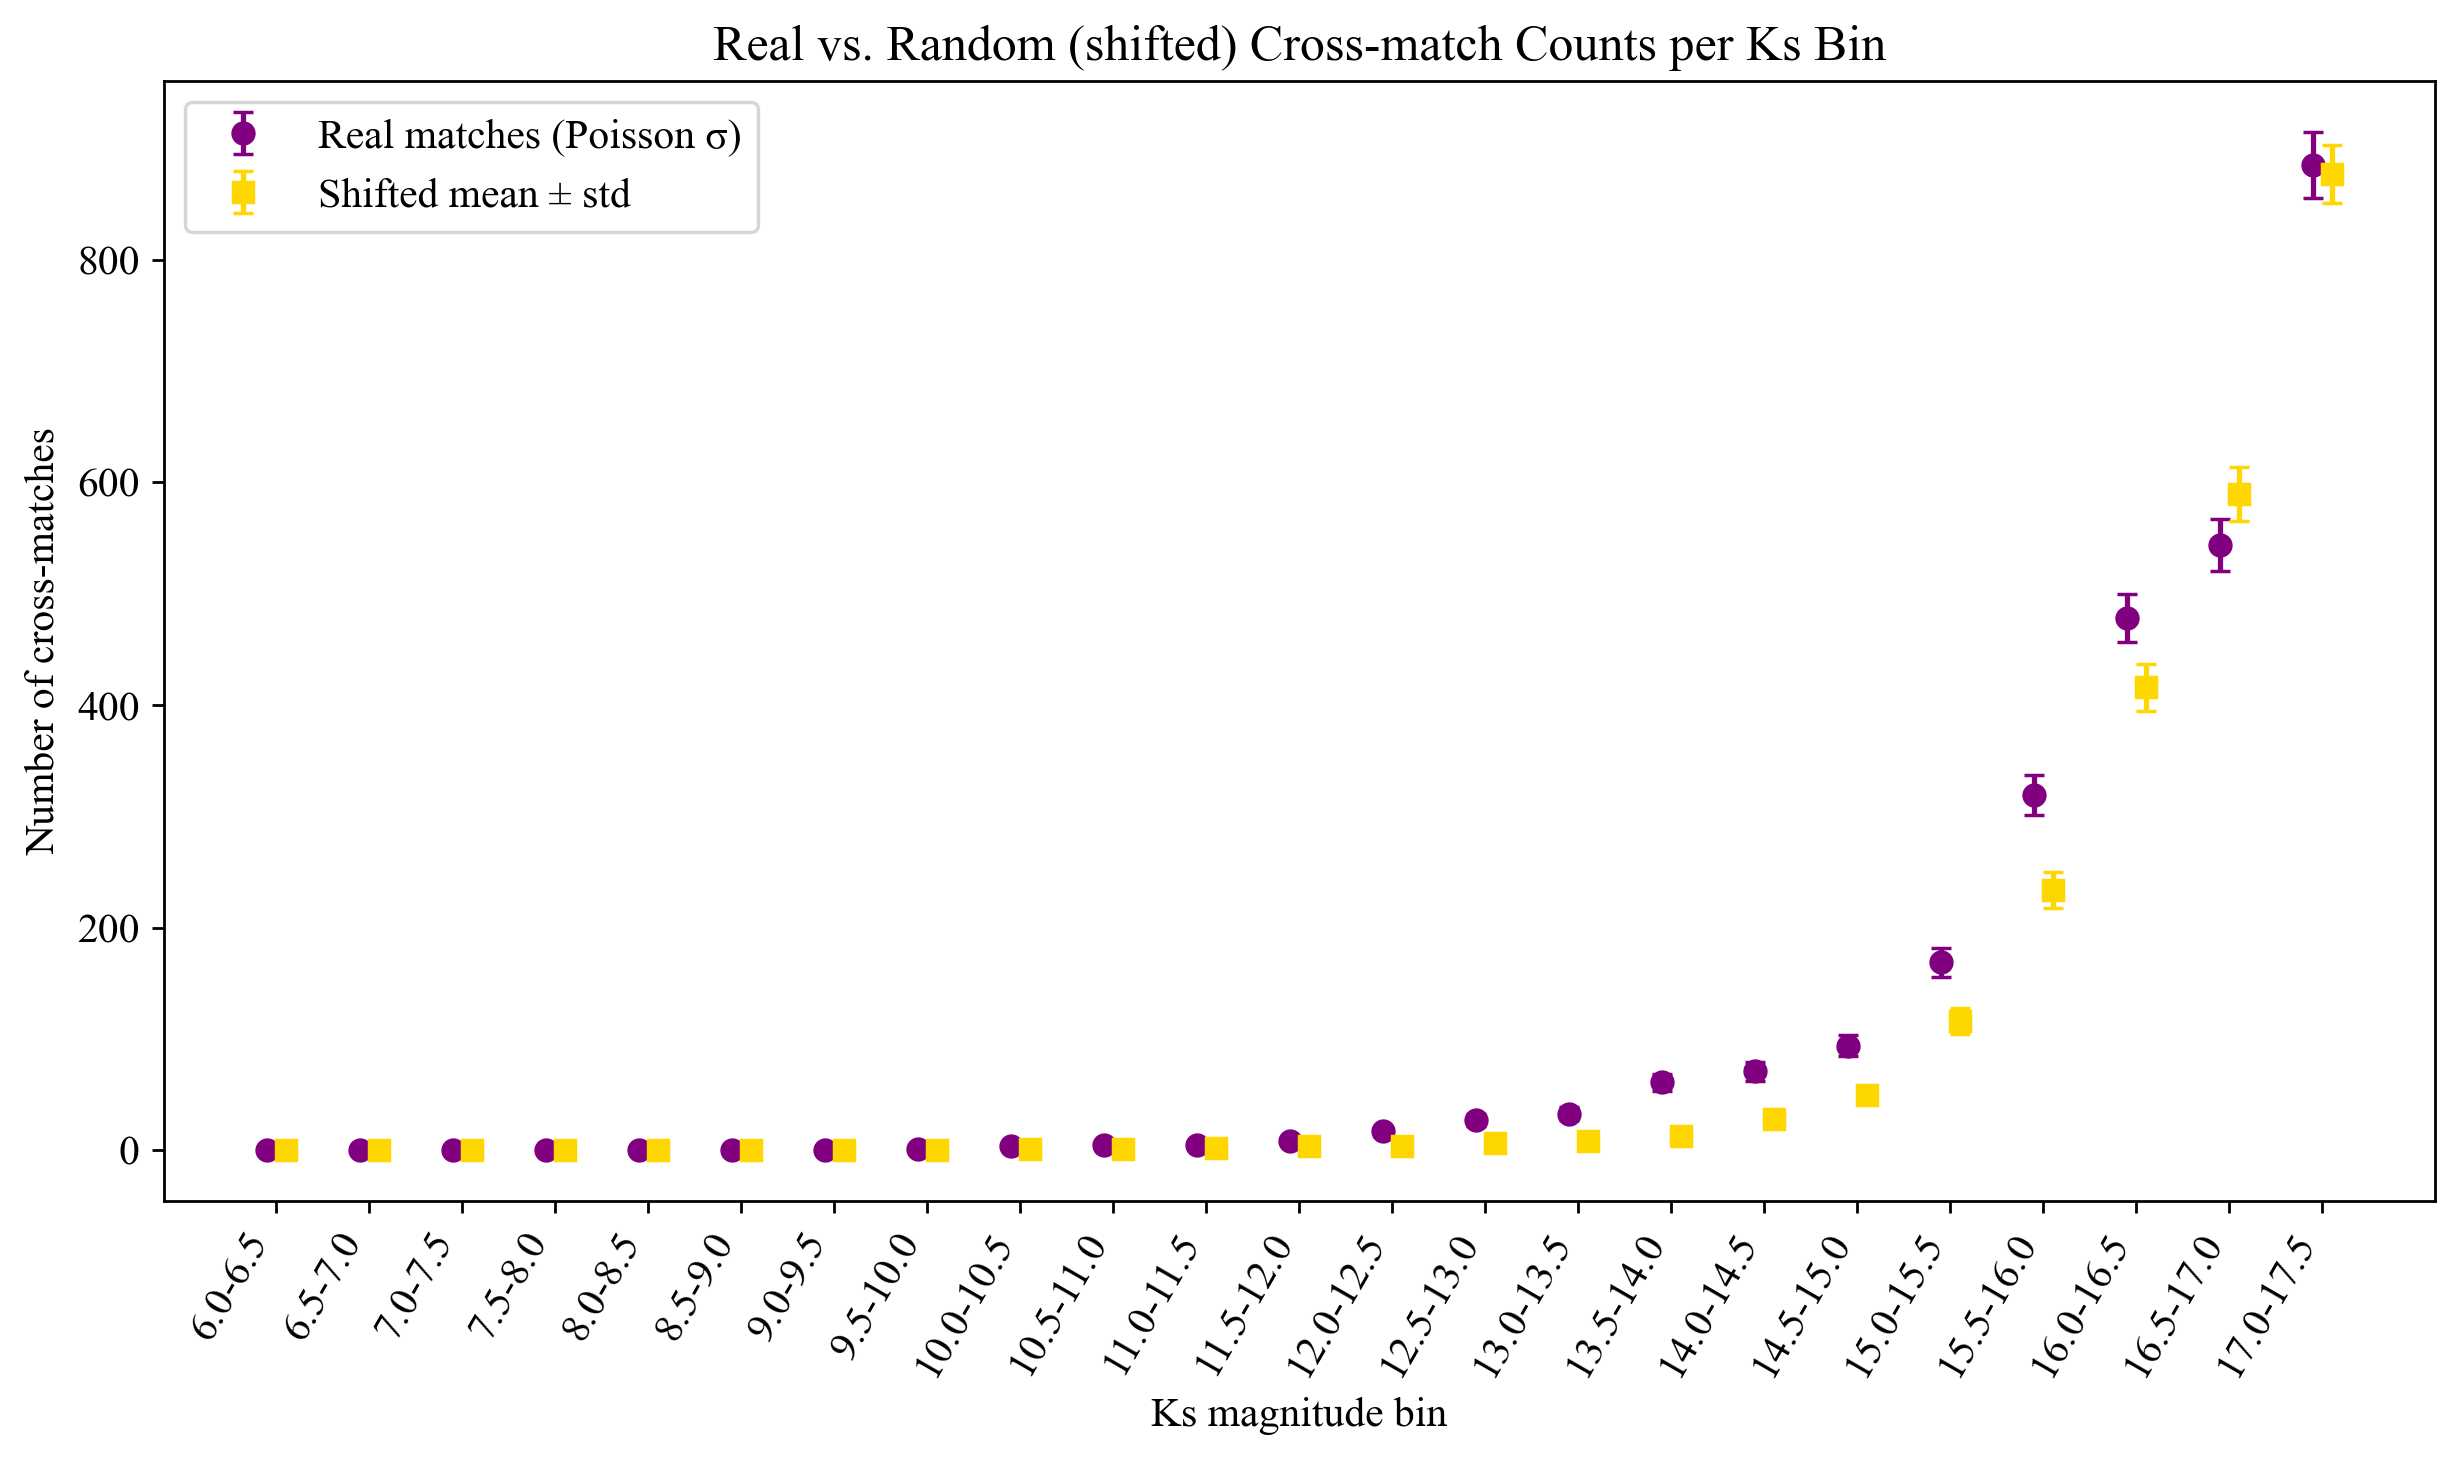

In [40]:
# === Plots ===

# ---- 1. Real vs Random matches with error bars per Ksmag bin ----
bin_labels = summary.index.to_list()

# Real (aligned) match counts and their Poisson uncertainty (sqrt(N))
real_counts = summary["N_matches"].to_numpy()
real_err = np.sqrt(real_counts)  # Poisson uncertainty; for zero counts this gives 0 which is fine visually
# Random/shifted trial statistics: mean and stddev per bin
random_mean = summary["N_random_mean"].to_numpy()
random_std = summary["N_random_std"].to_numpy()

x = np.arange(len(bin_labels))   # x positions for the grouped error bars

# Plot
plt.figure(figsize=(10, 6))

# Real matches: purple circles with vertical error bars (Poisson)
plt.errorbar(
    x - 0.1,                 # slight offset left for separation
    real_counts,
    yerr=real_err,
    fmt="o",
    color="purple",          # real in purple
    ecolor="purple",
    label="Real matches (Poisson σ)",
    capsize=3,
    markersize=6,
    linestyle="none",
)

# Shifted (random) background: yellow squares with ±1σ
plt.errorbar(
    x + 0.1,                 # slight offset right
    random_mean,
    yerr=random_std,
    fmt="s",
    color="gold",           # random in green
    ecolor="gold",
    label="Shifted mean ± std",
    capsize=3,
    markersize=6,
    linestyle="none",
)

plt.xticks(x, bin_labels, rotation=60, ha="right")  # bins on x-axis
plt.xlabel("Ks magnitude bin")
plt.ylabel("Number of cross-matches")
plt.title("Real vs. Random (shifted) Cross-match Counts per Ks Bin")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

**Plot explanation:**  
This plot compares the number of cross-matches in each $K_s$ magnitude bin between the real (astrometrically aligned) catalogs and the null expectation estimated via randomly shifted infrared catalogs. For each bin, the purple points show the measured number of real matches with Poisson error bars, and the yellow points show the mean number of matches from shifted trials with their standard deviation. The excess of real over shifted counts, especially where the purple markers lie significantly above the yellow, indicates magnitude ranges where genuine counterparts dominate over chance alignments.

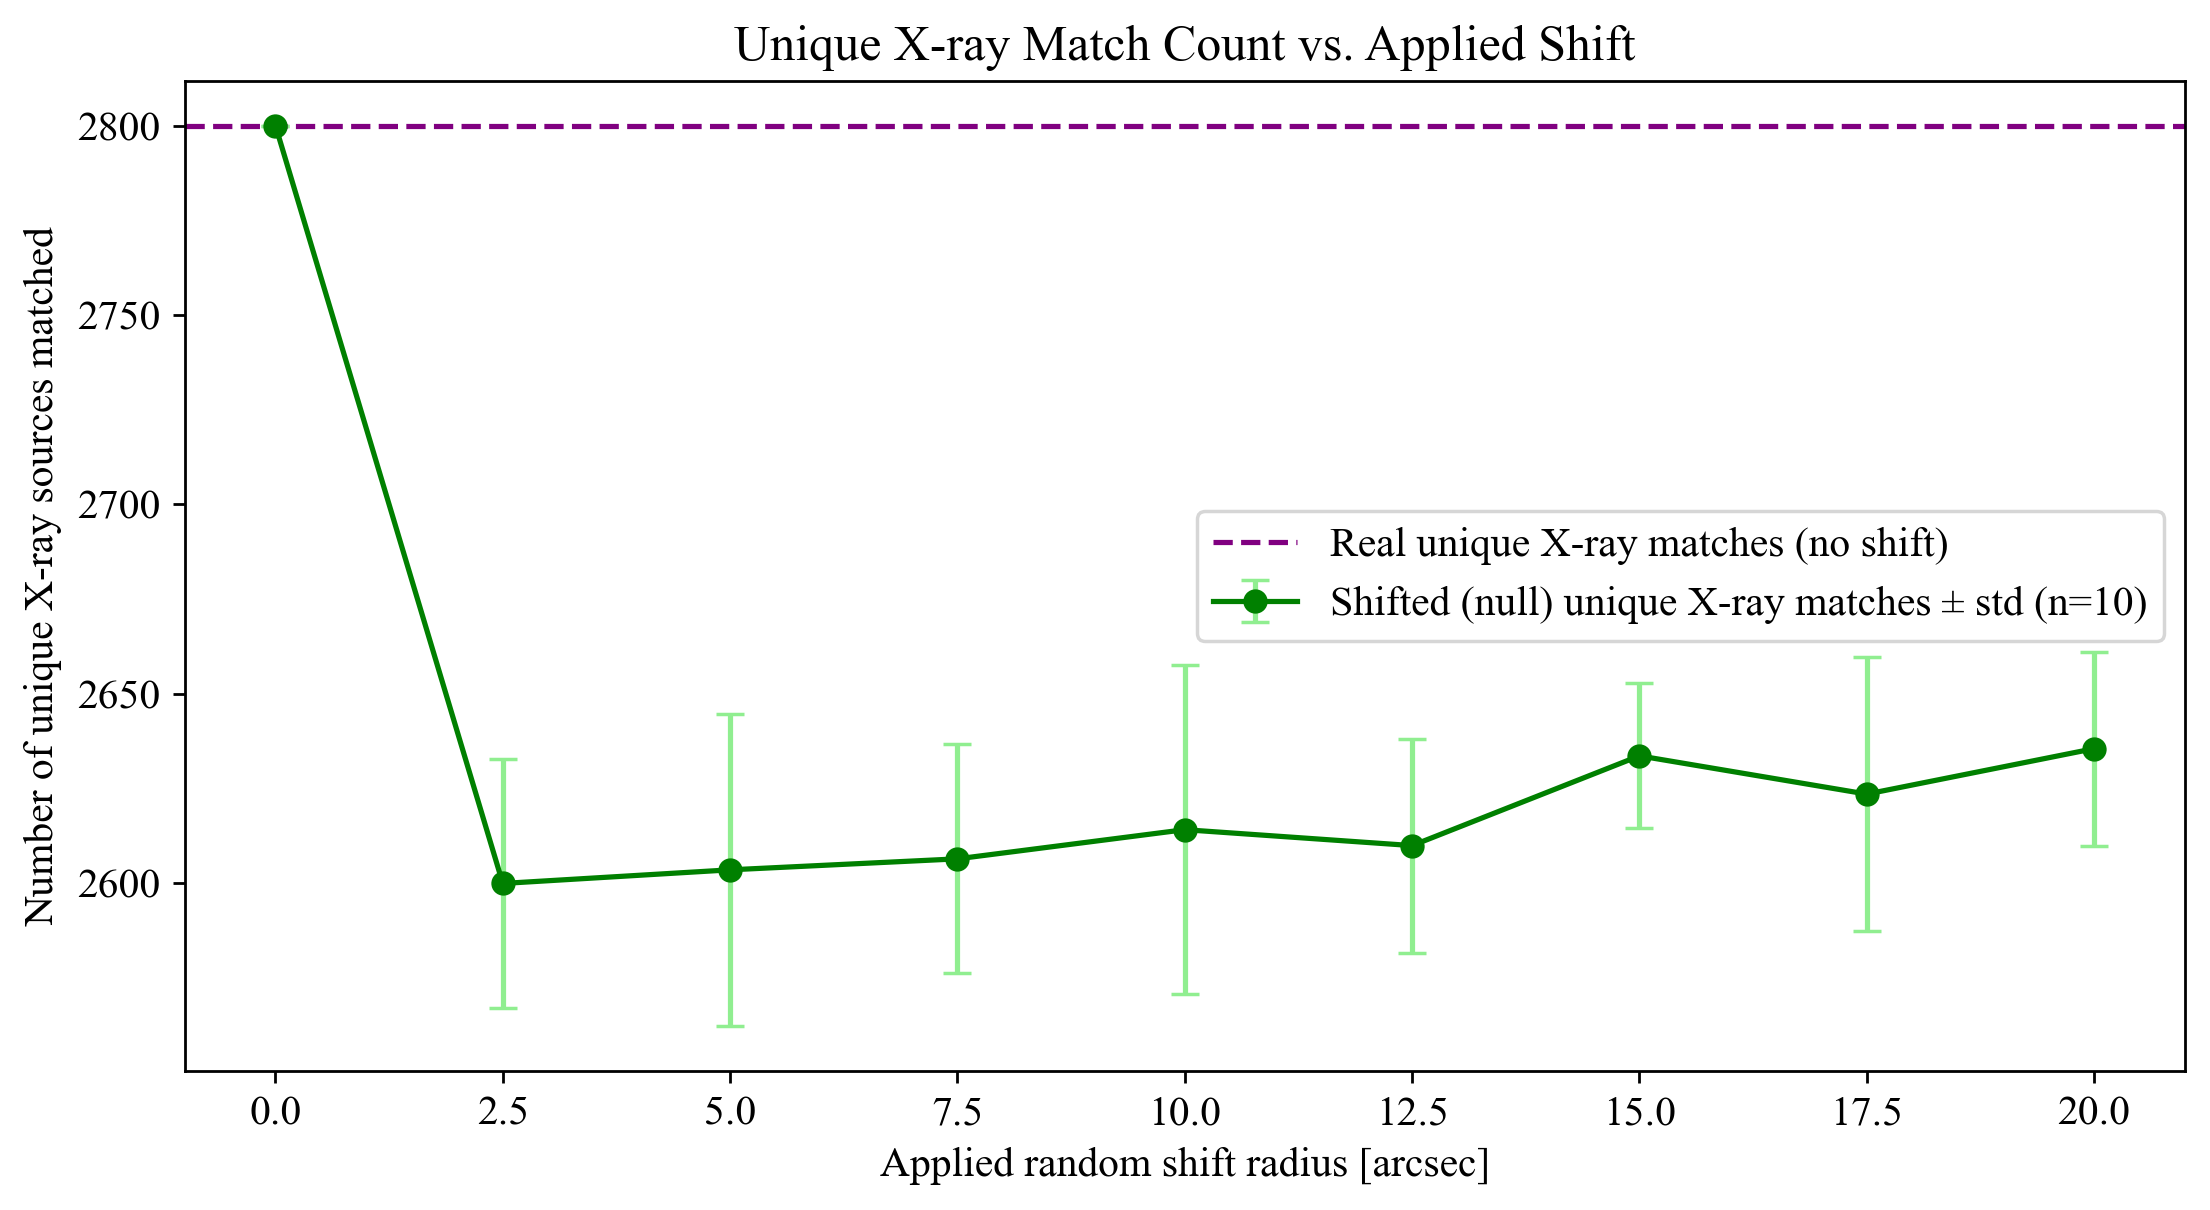

In [41]:
# ----- 2. Shift-radius dependence of matched unique X-ray sources -----
mean_matched = []
std_matched = []

for radius in shift_radii_arcsec:
    unique_counts = []
    for _ in range(n_trials_per_shift):
        _, pairs_shifted = crossmatch_muno_gn_quadrature(
            tbl_muno_clean=tbl_muno_clean,
            tbl_gn_clean=tbl_gn_clean,
            ks_bin_edges=ks_edges,  # still required by signature, result unused here
            sigma_ir_arcsec=sigma_ir_arcsec,
            use_shift=True,
            shift_radius_arcsec=radius,
        )
        # Number of distinct X-ray sources with at least one (shifted) match
        unique_xray = pairs_shifted["muno_index"].nunique()
        unique_counts.append(unique_xray)
    arr = np.array(unique_counts)
    mean_matched.append(arr.mean())
    std_matched.append(arr.std())

mean_matched = np.array(mean_matched)
std_matched = np.array(std_matched)

# Also get the unshifted unique matched X-ray count for reference
_, pairs_real = crossmatch_muno_gn_quadrature(
    tbl_muno_clean=tbl_muno_clean,
    tbl_gn_clean=tbl_gn_clean,
    ks_bin_edges=ks_edges,
    sigma_ir_arcsec=sigma_ir_arcsec,
    use_shift=False,
)
real_unique = pairs_real["muno_index"].nunique()

# Plot
plt.figure(figsize=(9, 5))
plt.errorbar(
    shift_radii_arcsec,
    mean_matched,
    yerr=std_matched,
    fmt="o-",
    color="green",
    ecolor="lightgreen",
    capsize=4,
    label=f"Shifted (null) unique X-ray matches ± std (n={n_trials_per_shift})",
)
plt.axhline(real_unique, color="purple", linestyle="--", label="Real unique X-ray matches (no shift)")
plt.xlabel("Applied random shift radius [arcsec]")
plt.ylabel("Number of unique X-ray sources matched")
plt.title("Unique X-ray Match Count vs. Applied Shift")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

**Plot explanation:**  
This plot shows how the number of unique X-ray sources that find at least one infrared counterpart changes as a function of the applied random shift radius to the IR catalog. Each green point represents the average number of unique matched X-ray sources over multiple null trials at that shift magnitude, with error bars showing the scatter. The dashed purple line is the benchmark count from the real (no-shift) cross-match. The decline of the null match count with increasing shift, and the separation between the real line and the null distribution at small shifts, demonstrate that the real matches are not due to spatially random coincidences.

# Probability of true match estimation

## Match probability formalism (following Mauerhan et al. 2009)

We want to quantify, for each candidate infrared counterpart to an X-ray source, the probability that the match is real (as opposed to a chance coincidence). This is done by combining three ingredients per candidate:

### 1. Separation likelihood $p(\phi)$

For each candidate match we compute the angular separation $\phi$ and the combined positional uncertainty:

$$
\sigma^2 = \sigma_X^2 + \sigma_{\text{IR}}^2,
$$

where $\sigma_X$ is the X-ray positional error (taken from `ePos`) and $\sigma_{\text{IR}}$ is the assumed fixed infrared uncertainty (e.g., $0.1''$). Then the separation likelihood is modeled as a Gaussian in the small-angle approximation:

$$
p(\phi) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{\phi^2}{2\sigma^2}\right).
$$

This gives higher weight to close-in matches relative to their combined error budget.

### 2. Detectability fraction $f(K)$

We build $f(K)$ on a grid of Ks magnitudes by asking: for a given limiting magnitude $K$, what fraction of X-ray sources have at least one real (unshifted) match with $K_{\text{smag}} \le K$? Formally,

$$
f(K)=\frac{\#\{\text{unique X-ray sources with some real match of } K_{\mathrm{smag}}\le K\}}{\text{total number of X-ray sources considered}}.
$$


Matches at arbitrary $K_i$ are assigned $f(K_i)$ by nearest-grid lookup to mirror the original methodology.

### 3. Background density $\rho(K)$

We estimate the cumulative background surface density of infrared sources brighter than $K$ as:

$$
\rho(K) = \frac{N(K_{\text{smag}} \le K)}{\text{survey area}},
$$

where the survey area is approximated from the bounding RA/Dec rectangle (with declination projection correction) and converted to arcsecond$^2$.

### 4. Combined weight and normalization

For each candidate match $i$ (with magnitude $K_i$, separation $\phi_i$), define the unnormalized weight:

$$
T_i = \frac{f(K_i)}{\rho(K_i)} \, p(\phi_i).
$$

Let $f_{\text{lim}} \equiv f(K_{\text{max}})$ be the detectability at the faintest magnitude. Then for each X-ray source with multiple candidates, we enforce that the total probability (including the "no counterpart" term $P_0$) sums to unity:

$$
c^{-1} = \sum_i T_i + (1 - f_{\text{lim}}),
$$

so that:

$$
P_i = c\, T_i, \quad P_0 = c\,(1 - f_{\text{lim}}).
$$

Here, **$P_i$** is the probability that candidate $i$ is the **true counterpart**, and **$P_0$** is the probability that **none of the candidates is real**.

### 5. Implementation details

- Nearest-grid lookup is used for $f(K_i)$ and $\rho(K_i)$ to stay faithful to the discrete evaluation in the reference.  
- A small floor is applied to $\rho(K)$ to avoid division by zero.  
- The full candidate-level table is stored in `probabilities`; the best per X-ray source is taken as the candidate with the largest $P_i$ and stored in `best_match`.  
- Normalization is validated by checking that for each X-ray source:

$$
\sum_i P_i + P_0 \approx 1,
$$

and any significant deviations are flagged.

### Outputs

- `probabilities`: full table with all candidates and their $P_i$, $P_0$, $f(K)$, $\rho(K)$, and $p(\phi)$.  
- `best_match`: highest-probability counterpart per X-ray source with normalization diagnostics.  
- Diagnostic summaries include shapes, normalization residuals, and top-ranked candidate probabilities.

In [ ]:
# === Required ingredients for probability calculation ===

# Constants
sigma_ir_arcsec = 0.1  # fixed IR positional uncertainty
sigma_ir = sigma_ir_arcsec * u.arcsec


# ----- f(K): fraction of X-ray sources with at least one match brighter than or equal to K -----
# Extract all unique Muno (X-ray) sources that have at least one real (unshifted) match and their matched Ksmag values
xray_match_df = pairs_real[["muno_index", "Ksmag"]].copy()

# Define the K grid (same as before)
ks_grid = np.arange(6.0, 17.6, 0.5)  # up to 17.5

# For each K_i in grid, compute f(K_i): number of unique X-ray sources with some match of K <= K_i
total_xray_sources = len(np.unique(pairs_real["muno_index"]))  # or ideally the number of X-ray sources considered for matching (hard/soft subset)

f_K_vals = []
for K_lim in ks_grid:
    mask = xray_match_df["Ksmag"] <= K_lim
    n_with = xray_match_df.loc[mask, "muno_index"].nunique()
    f_K_vals.append(n_with / total_xray_sources if total_xray_sources > 0 else 0.0)
f_K = pd.Series(f_K_vals, index=ks_grid)  # f(K) at each grid point


def lookup_f_K(K_array):
    """ Find nearest grid index for each K_i (clip to bounds) """
    K_array = np.clip(K_array, ks_grid[0], ks_grid[-1])
    idx = np.abs(K_array[:, None] - ks_grid[None, :]).argmin(axis=1)
    return f_K.values[idx]
    
    
# ----- rho(K): background density of IR (GN) sources with K <= K_i -----
# Need the IR catalog's Ksmag column cleaned and numeric
gn_df = tbl_gn_clean.to_pandas() if hasattr(tbl_gn_clean, "to_pandas") else pd.DataFrame(tbl_gn_clean)
gn_df["Ksmag"] = pd.to_numeric(gn_df["Ksmag"], errors="coerce")

# Estimate survey area: approximate bounding box in deg^2 then convert to arcsec^2
ra = pd.to_numeric(gn_df["RAJ2000"], errors="coerce")
dec = pd.to_numeric(gn_df["DEJ2000"], errors="coerce")
# Simple area estimate: (max RA - min RA) * (max Dec - min Dec) * cos(mean Dec) in deg^2
delta_ra = ra.max() - ra.min()
delta_dec = dec.max() - dec.min()
mean_dec_rad = np.deg2rad(dec.mean())
area_deg2 = delta_ra * delta_dec * np.cos(mean_dec_rad)
area_arcsec2 = area_deg2 * (3600.0 ** 2)  # deg^2 -> arcsec^2

# For each K_lim compute cumulative background density rho(K) = N(Ksmag <= K_lim) / area
rho_vals = []
for K_lim in ks_grid:
    n_ir = np.sum(gn_df["Ksmag"] <= K_lim)
    rho_vals.append(n_ir / area_arcsec2)  # per arcsec^2
rho_K = pd.Series(rho_vals, index=ks_grid)

def lookup_rho_K(K_array):
    """Nearest-grid lookup of rho(K) for arbitrary K_i values."""
    K_array = np.clip(K_array, ks_grid[0], ks_grid[-1])
    idx = np.abs(K_array[:, None] - ks_grid[None, :]).argmin(axis=1)
    return rho_K.values[idx]


# ----- p(phi): per-candidate separation likelihood, for each candidate match in pairs_real -----
# Candidate magnitudes
K_i = pairs_real["Ksmag"].to_numpy(dtype=float)
f_K_i = lookup_f_K(K_i)       # f(K_i) per candidate
rho_K_i = lookup_rho_K(K_i)   # rho(K_i) per candidate

# Need per-pair sigma_x (from Muno ePos) and separation in consistent units (radians)
muno_df = tbl_muno_clean.to_pandas() if hasattr(tbl_muno_clean, "to_pandas") else pd.DataFrame(tbl_muno_clean)

# restrict to those used in pairs_real: indices are muno_index after valid filtering inside crossmatch function
# get ePos array aligned to the muno_index space used in pairs_real
sigma_x_arcsec = pd.to_numeric(muno_df.loc[pairs_real["muno_index"], "ePos"], errors="coerce").to_numpy(dtype=float)
sigma_x = sigma_x_arcsec * u.arcsec

# Angular separations in radians
phi_arcsec = pairs_real["separation_arcsec"].to_numpy()
phi_rad = (phi_arcsec * u.arcsec).to(u.rad).value  # pure float in radians

# Combined positional uncertainty (quadrature): sqrt(sigma_x^2 + sigma_ir^2)
sigma_total = np.sqrt(sigma_x.to_value(u.arcsec)**2 + sigma_ir.value**2) * u.arcsec
sigma_total_rad = sigma_total.to(u.rad).value

# p(phi): Gaussian (2D small-angle) likelihood of observing separation given uncertainty
p_phi = (1.0 / (2 * np.pi * sigma_total_rad**2)) * np.exp(-0.5 * (phi_rad / sigma_total_rad)**2)

In [63]:
# === Probability calculation: build weight T_i and normalize to get P_i and P_0 ===

# Assemble base candidate DataFrame
prob_df = pairs_real[["muno_index", "gn_index"]].copy()
prob_df["Ksmag"] = K_i
prob_df["f_K"] = f_K_i
prob_df["rho_K"] = rho_K_i
prob_df["p_phi"] = p_phi

# Weight term T_i = (f(K_i)/rho(K_i)) * p_phi_i, guard against zero background density
epsilon = 1e-30
prob_df["T_i"] = (prob_df["f_K"] / prob_df["rho_K"].clip(lower=epsilon)) * prob_df["p_phi"]

# f_lim for the no-counterpart probability P_0
f_lim = f_K.iloc[-1]

# Normalize per X-ray source to produce P_i and P_0
results = []
for xray_idx, group in prob_df.groupby("muno_index"):
    T_vec = group["T_i"].to_numpy()
    denom = T_vec.sum() + (1.0 - f_lim)  # inverse normalizer
    if denom <= 0:
        c = 0.0
        P0 = 1.0
        P_i_vec = np.zeros_like(T_vec)
    else:
        c = 1.0 / denom
        P0 = c * (1.0 - f_lim)
        P_i_vec = c * T_vec

    g = group.copy()
    g["P_i"] = P_i_vec
    g["P_0"] = P0
    results.append(g)

# Full per-candidate probability table
probabilities = pd.concat(results, ignore_index=True)

# Summarize normalization and extract best match per X-ray source
sum_Pi = probabilities.groupby("muno_index", observed=False)["P_i"].sum()
P0_series = probabilities.groupby("muno_index", observed=False)["P_0"].first()
norm = sum_Pi + P0_series  # should be ~1

norm_df = pd.DataFrame({
    "norm": norm,
    "sum_Pi": sum_Pi,
    "P0": P0_series
}).reset_index()

best_match = (
    probabilities
    .sort_values(["muno_index", "P_i"], ascending=[True, False])
    .groupby("muno_index", observed=False, as_index=False)
    .first()
)
best_match = best_match.merge(norm_df, on="muno_index", how="left")

# === Diagnostics / reporting ===
print(f"Full probability table shape: {probabilities.shape}")
print(f"Best-match table shape: {best_match.shape}\n")
display(best_match.head(5))
print("Normalization summary (should be ~1):")
print(norm.describe())
tol = 1e-6
bad_norm = norm[(norm < 1 - tol) | (norm > 1 + tol)]
print(f"Number of X-ray sources with poor normalization (> {tol:.1e} off): {len(bad_norm)}")

Full probability table shape: (7504, 9)
Best-match table shape: (2800, 12)



,muno_index,gn_index,Ksmag,f_K,rho_K,p_phi,T_i,P_i,P_0,norm,sum_Pi,P0
0,2,277731,0.0000,0.239286,0.033437,2.967781e+09,2.123843e+10,0.362947,4.278398e-12,1.0,1.0,4.278398e-12
1,3,55133,16.6424,0.517500,0.048434,1.558602e+09,1.665301e+10,0.175422,2.637246e-12,1.0,1.0,2.637246e-12
2,4,248649,0.0000,0.239286,0.033437,2.959534e+09,2.117942e+10,0.289707,3.424566e-12,1.0,1.0,3.424566e-12
3,5,946057,16.3634,0.517500,0.048434,9.889049e+08,1.056604e+10,0.612675,1.451703e-11,1.0,1.0,1.451703e-11
4,6,248734,0.0000,0.239286,0.033437,3.881739e+09,2.777902e+10,0.173689,1.565360e-12,1.0,1.0,1.565360e-12


Normalization summary (should be ~1):
count    2.800000e+03
mean     1.000000e+00
std      1.013816e-16
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64
Number of X-ray sources with poor normalization (> 1.0e-06 off): 0


In [65]:
# Highest probability candidates (per X-ray, best match already in best_matches)
# We sort globally by P_i to see the strongest individual matches
top_candidates = probabilities.sort_values("P_i", ascending=False).head(15)
display(top_candidates[["muno_index", "gn_index", "Ksmag", "P_i", "P_0"]])

,muno_index,gn_index,Ksmag,P_i,P_0
2150,2002,875216,16.3372,1.0,3.588763e-13
2228,2183,870336,17.7412,1.0,3.748058e-13
2124,1949,869576,17.6371,1.0,3.837765e-13
2419,2534,883358,17.2146,1.0,3.846766e-13
2403,2501,882640,16.5847,1.0,3.920305e-13
2411,2513,880910,15.7299,1.0,3.976081e-13
1838,1507,874848,16.3102,1.0,4.013487e-13
2279,2288,869681,17.5995,1.0,4.030709e-13
2128,1953,889438,16.1313,1.0,4.111412e-13
2284,2305,866742,16.6415,1.0,4.121186e-13


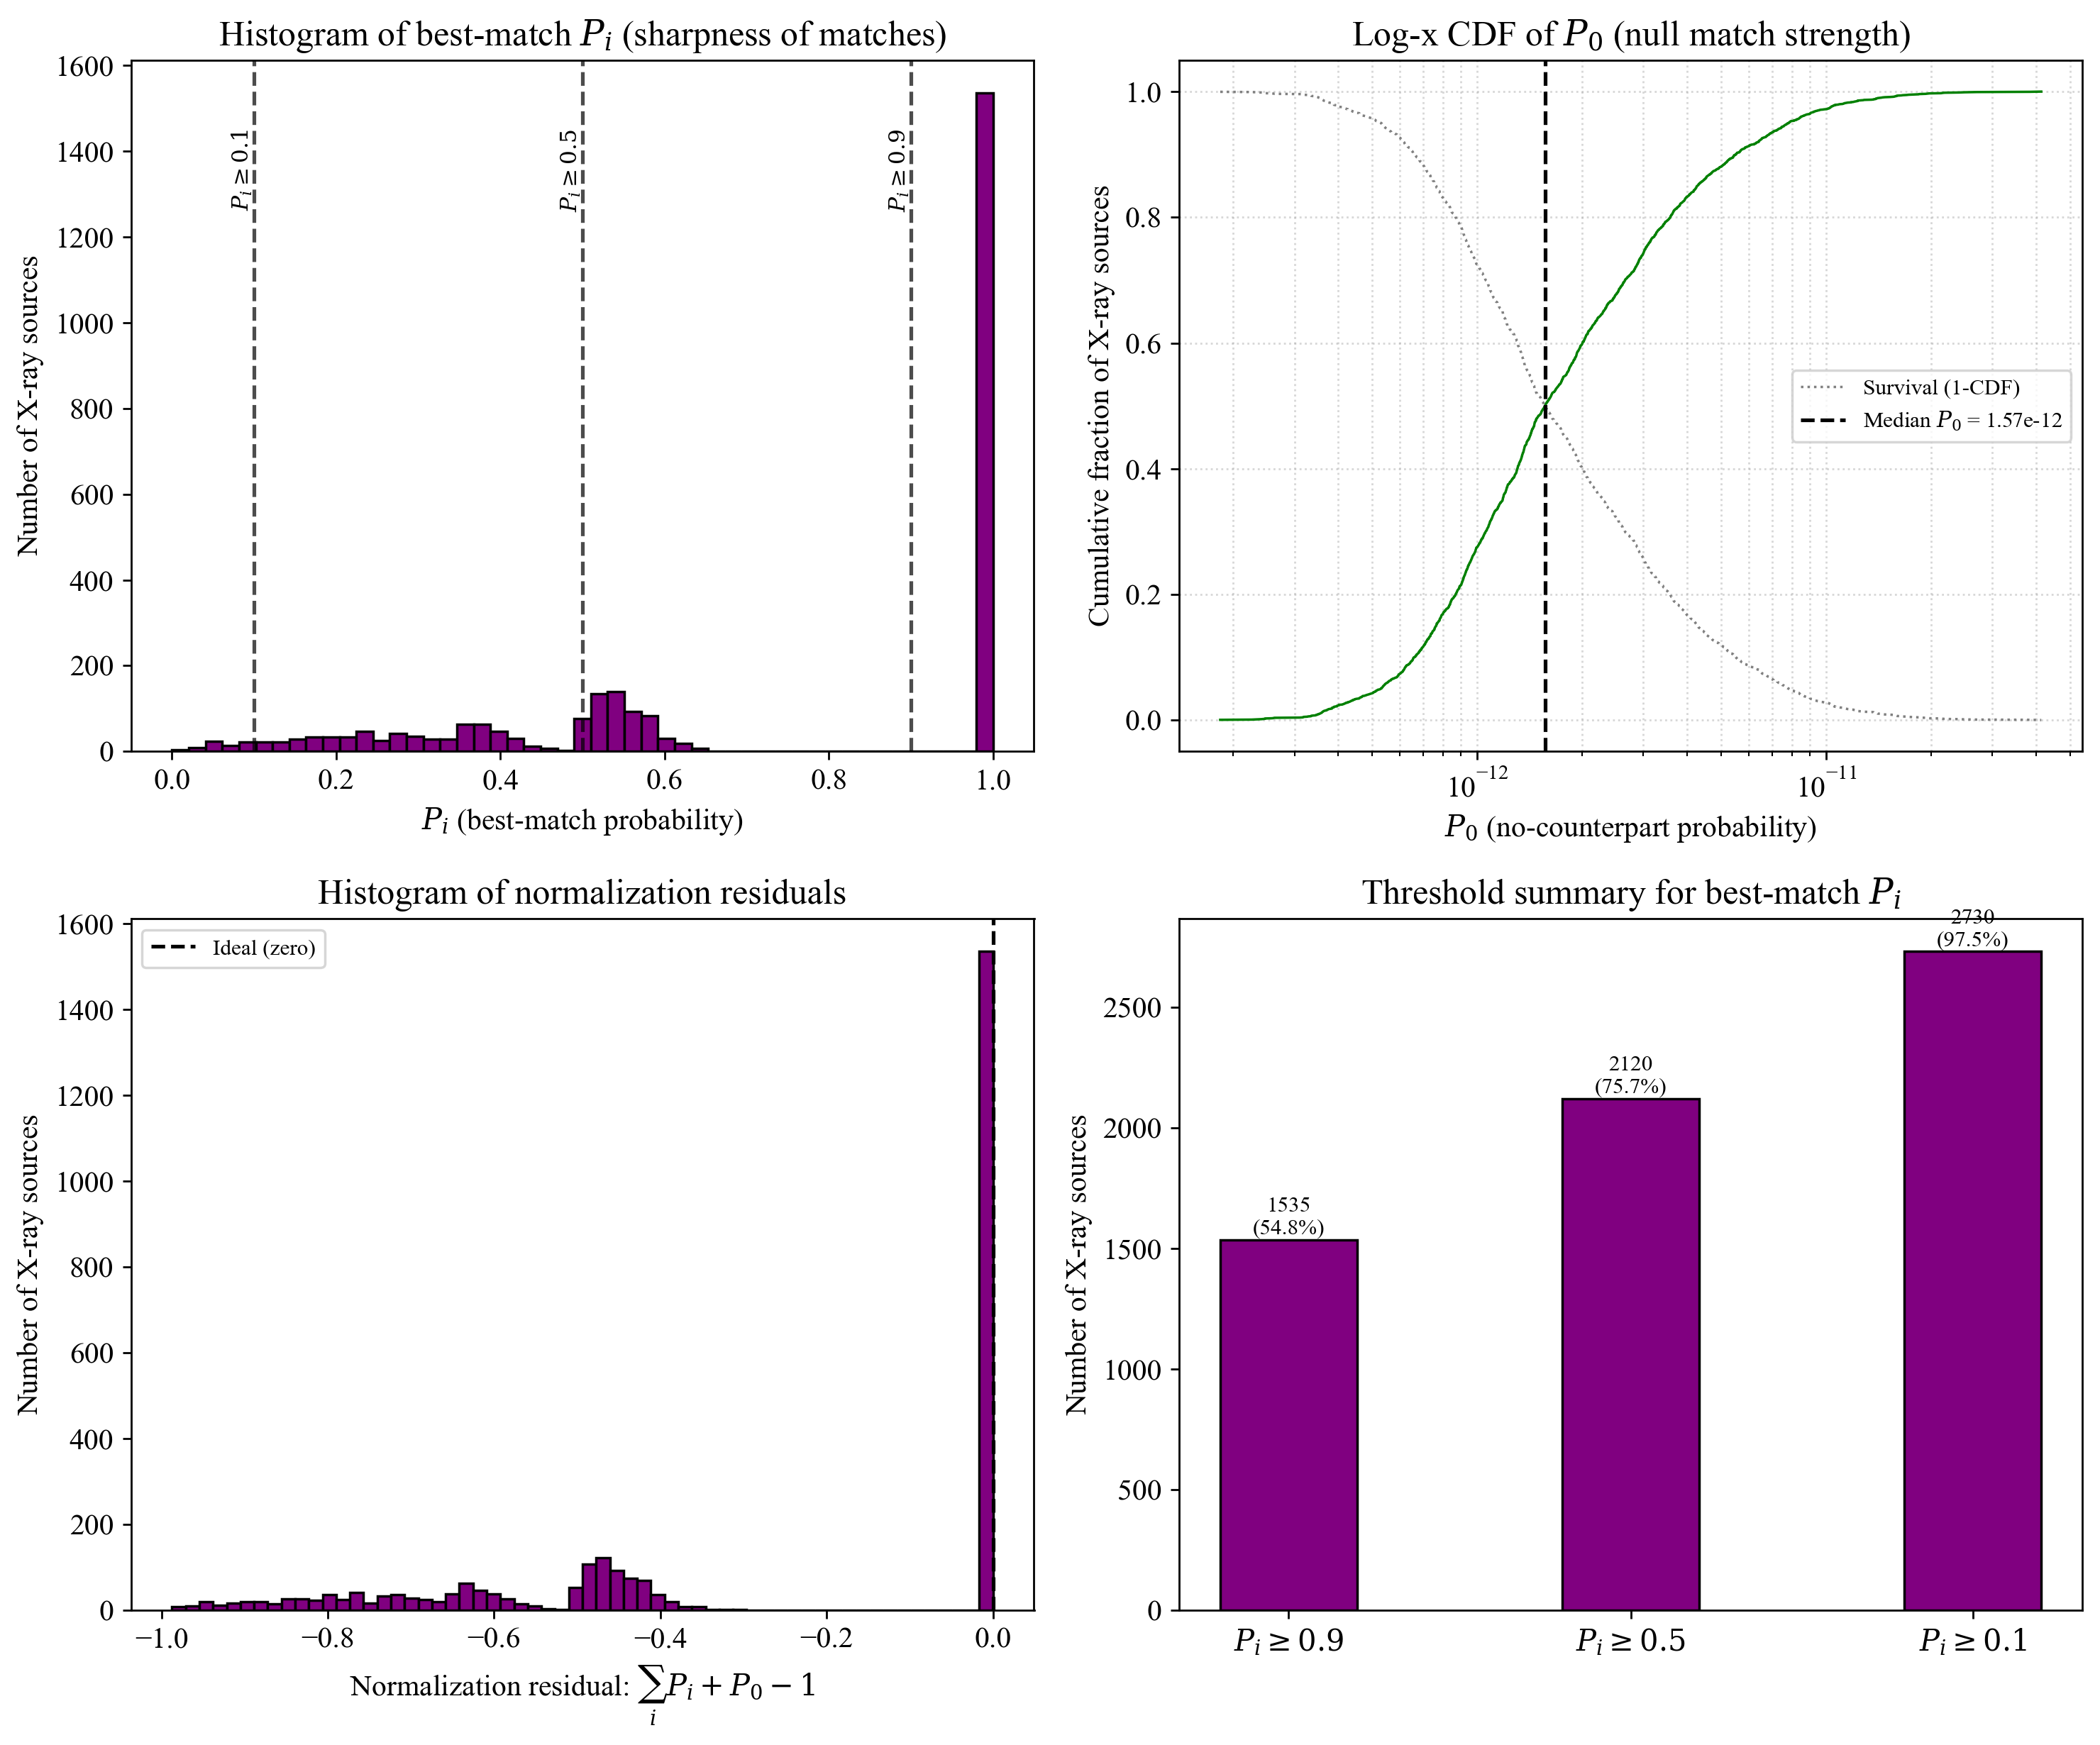

In [68]:
# === Plots ===

# Prepare derived quantities
# 1. Normalization residual per X-ray source: sum_i P_i + P_0 - 1
#    (should cluster near zero if probabilities were normalized correctly)
sum_Pi = best_match.groupby("muno_index", observed=False)["P_i"].sum()
P0 = best_match.groupby("muno_index", observed=False)["P_0"].first()
normalization_residual = (sum_Pi + P0) - 1.0  # Series indexed by muno_index

# 2. Best-match Pi values (one per X-ray source)
#    We already have one row per X-ray in best_match for the "best" candidate, 
#    so just extract P_i and P_0 from that table
Pi_values = best_match.set_index("muno_index")["P_i"]
P0_values = best_match.set_index("muno_index")["P_0"]

# Plotting

# Figure layout: 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ax_hist_pi, ax_cdf_p0, ax_norm, ax_threshold = axes.flat

# ----- Histogram of best-match P_i -----
bins = np.linspace(0, 1, 50)
ax_hist_pi.hist(Pi_values, bins=bins, color="purple", edgecolor="black")
# mark some typical thresholds
for thresh in [0.1, 0.5, 0.9]:
    ax_hist_pi.axvline(thresh, color="k", linestyle="--", alpha=0.7)
    ax_hist_pi.text(thresh, ax_hist_pi.get_ylim()[1]*0.9, f"$P_i\\geq{thresh}$", 
                    rotation=90, va="top", ha="right", fontsize=9)
ax_hist_pi.set_xlabel(r"$P_i$ (best-match probability)")
ax_hist_pi.set_ylabel("Number of X-ray sources")
ax_hist_pi.set_title("Histogram of best-match $P_i$ (sharpness of matches)")
ax_hist_pi.grid(False)

# ----- Log-x CDF of P0 -----
# Sort values and compute empirical CDF
sorted_P0 = np.sort(P0_values.to_numpy())
N = len(sorted_P0)
ecdf = np.arange(1, N+1) / N  # empirical CDF

# Avoid zeros for log plotting: mask zeros (should be tiny anyway)
mask_positive = sorted_P0 > 0
ax_cdf_p0.plot(sorted_P0[mask_positive], ecdf[mask_positive], color="green", lw=1)
# survival function (1 - CDF)
ax_cdf_p0.plot(sorted_P0[mask_positive], 1 - ecdf[mask_positive], 
               color="gray", lw=1, linestyle=":", label="Survival (1-CDF)")

# median P0 line
median_p0 = np.median(P0_values)
ax_cdf_p0.axvline(median_p0, color="black", linestyle="--", label=f"Median $P_0$ = {median_p0:.2e}")
ax_cdf_p0.set_xscale("log")
ax_cdf_p0.set_xlabel(r"$P_0$ (no-counterpart probability)")
ax_cdf_p0.set_ylabel("Cumulative fraction of X-ray sources")
ax_cdf_p0.set_title("Log-x CDF of $P_0$ (null match strength)")
ax_cdf_p0.legend(fontsize=9)
ax_cdf_p0.grid(True, which="both", ls=":", alpha=0.5)

# ----- Normalization residual histogram -----
# Residual should be near zero; show distribution
ax_norm.hist(normalization_residual.to_numpy(), bins=60, color="purple", edgecolor="black")
ax_norm.axvline(0, color="black", linestyle="--", label="Ideal (zero)")
ax_norm.set_xlabel(r"Normalization residual: $\sum_i P_i + P_0 - 1$")
ax_norm.set_ylabel("Number of X-ray sources")
ax_norm.set_title("Histogram of normalization residuals")
ax_norm.legend(fontsize=9)
ax_norm.grid(False)

# ----- Threshold summary: counts/fractions above P_i cutoffs -----
thresholds = [0.9, 0.5, 0.1]
counts = [(Pi_values >= t).sum() for t in thresholds]
fractions = [ (Pi_values >= t).mean() for t in thresholds ]

# Bar chart of counts with fraction labels
x = np.arange(len(thresholds))
width = 0.4
bars = ax_threshold.bar(x, counts, width, color="purple", edgecolor="black")
ax_threshold.set_xticks(x)
ax_threshold.set_xticklabels([f"$P_i\\geq{t}$" for t in thresholds])
ax_threshold.set_ylabel("Number of X-ray sources")
ax_threshold.set_title("Threshold summary for best-match $P_i$")
# annotate counts and fractions above bars
for i, bar in enumerate(bars):
    h = bar.get_height()
    ax_threshold.text(bar.get_x() + bar.get_width()/2, h + 5,
                      f"{counts[i]}\n({fractions[i]*100:.1f}%)",
                      ha="center", va="bottom", fontsize=9)
ax_threshold.grid(False)

plt.tight_layout()
plt.show()

## Diagnostic plots for match probability quality

### Histogram of best-match $P_i$  
Shows how sharply peaked the counterpart probabilities are for each X-ray source. High values of $P_i$ (close to 1) imply confident, unambiguous matches; low or broadly distributed $P_i$ indicates ambiguity or weak counterparts. We look for a concentration near $P_i \ge 0.9$, which suggests strong identifications. Vertical lines mark common selection thresholds to aid cutoff decisions.

### Log-x CDF of $P_0$  
Quantifies how many X-ray sources lack a good infrared counterpart. $P_0$ is the probability that *none* of the candidates is real. The cumulative distribution shows the fraction of X-ray sources with various levels of “no-match” likelihood. We look for a steep rise at low $P_0$, which means most sources have plausible counterparts; a long tail to high $P_0$ reveals many isolated or ambiguous sources. The survival function (1−CDF) highlights rare high-$P_0$ cases. The median line summarizes typical behavior.

### Histogram of normalization residuals  
Sanity-checks that the probability normalization holds per X-ray source. For each X-ray source, $\sum_i P_i + P_0 \approx 1$ should be true; deviations indicate numerical issues or degenerate cases. We look for residuals tightly clustered around zero; large outliers are worth investigating.

### Threshold summary for best-match $P_i$  
Translates continuous match confidence into discrete, actionable categories. Downstream analysis requires counts of high-confidence counterparts (e.g., $P_i \ge 0.9$). We pay attention to the number and fraction of X-ray sources passing each threshold.

# General Diagnostic and Environmental Plots

## 1. Catalogs overlay

Overlay of the Muno X-ray catalog with the GALACTICNUCLEUS and VVV infrared catalogs in RA/Dec. Provides a broad visual check of astrometric alignment, relative source densities, and coverage overlap between the X-ray and NIR datasets.

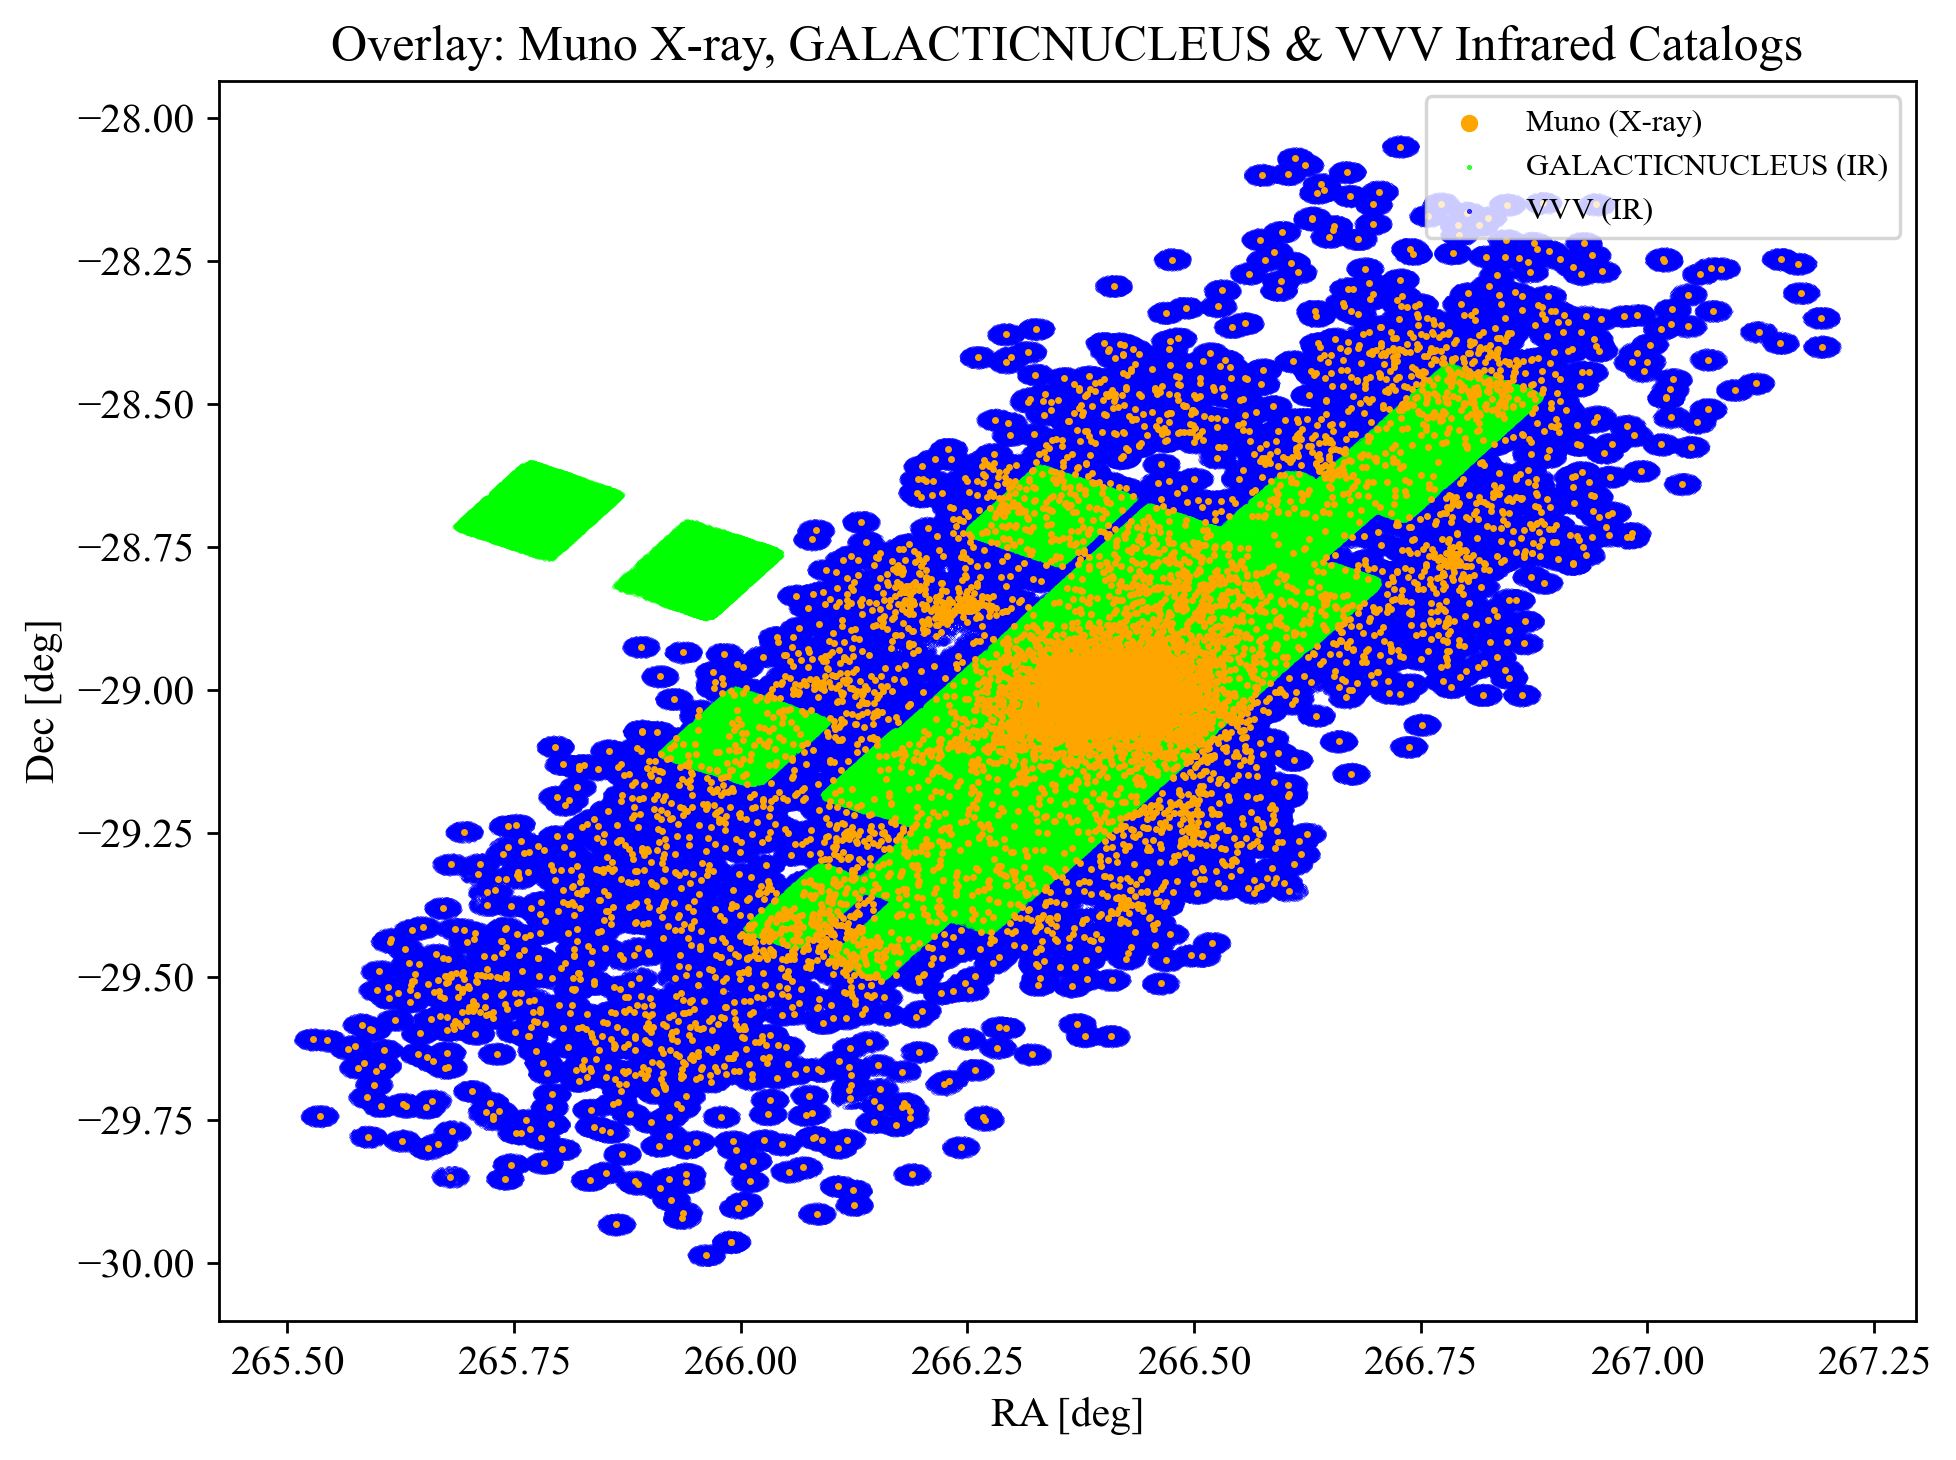

In [137]:
# === Catalogs Overlay: X-ray (Muno), Infrared (GALACTICNUCLEUS, VVV) ===
plt.figure(figsize=(8, 6))

# Muno X-ray sources
plt.scatter(muno_ra_deg, muno_dec_deg, color="orange", s=1, zorder=2, label="Muno (X-ray)")

# GALACTICNUCLEUS IR sourcesb
plt.scatter(gn_ra_deg, gn_dec_deg, color="lime", s=0.01, alpha=1, zorder=1, label="GALACTICNUCLEUS (IR)")

# VVV IR sources
plt.scatter(vvv_ra_deg, vvv_dec_deg, color='blue', s=0.01, alpha=1, zorder=0, label = 'VVV (IR)')

plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("Overlay: Muno X-ray, GALACTICNUCLEUS & VVV Infrared Catalogs")

# Optional: invert x-axis if desired to follow astronomical convention (RA increasing to the left)
# plt.gca().invert_xaxis()

plt.legend(loc="upper right", markerscale=4, fontsize=9)
plt.grid(False)
plt.tight_layout()
plt.show()

## 2. IR Density around HMXB candidates

For each of the strongest HMXB candidates, a panel showing nearby IR sources within a 3′ radius and the local surface density compared to the global average. Separate versions are produced for the GALACTICNUCLEUS and VVV catalogs.

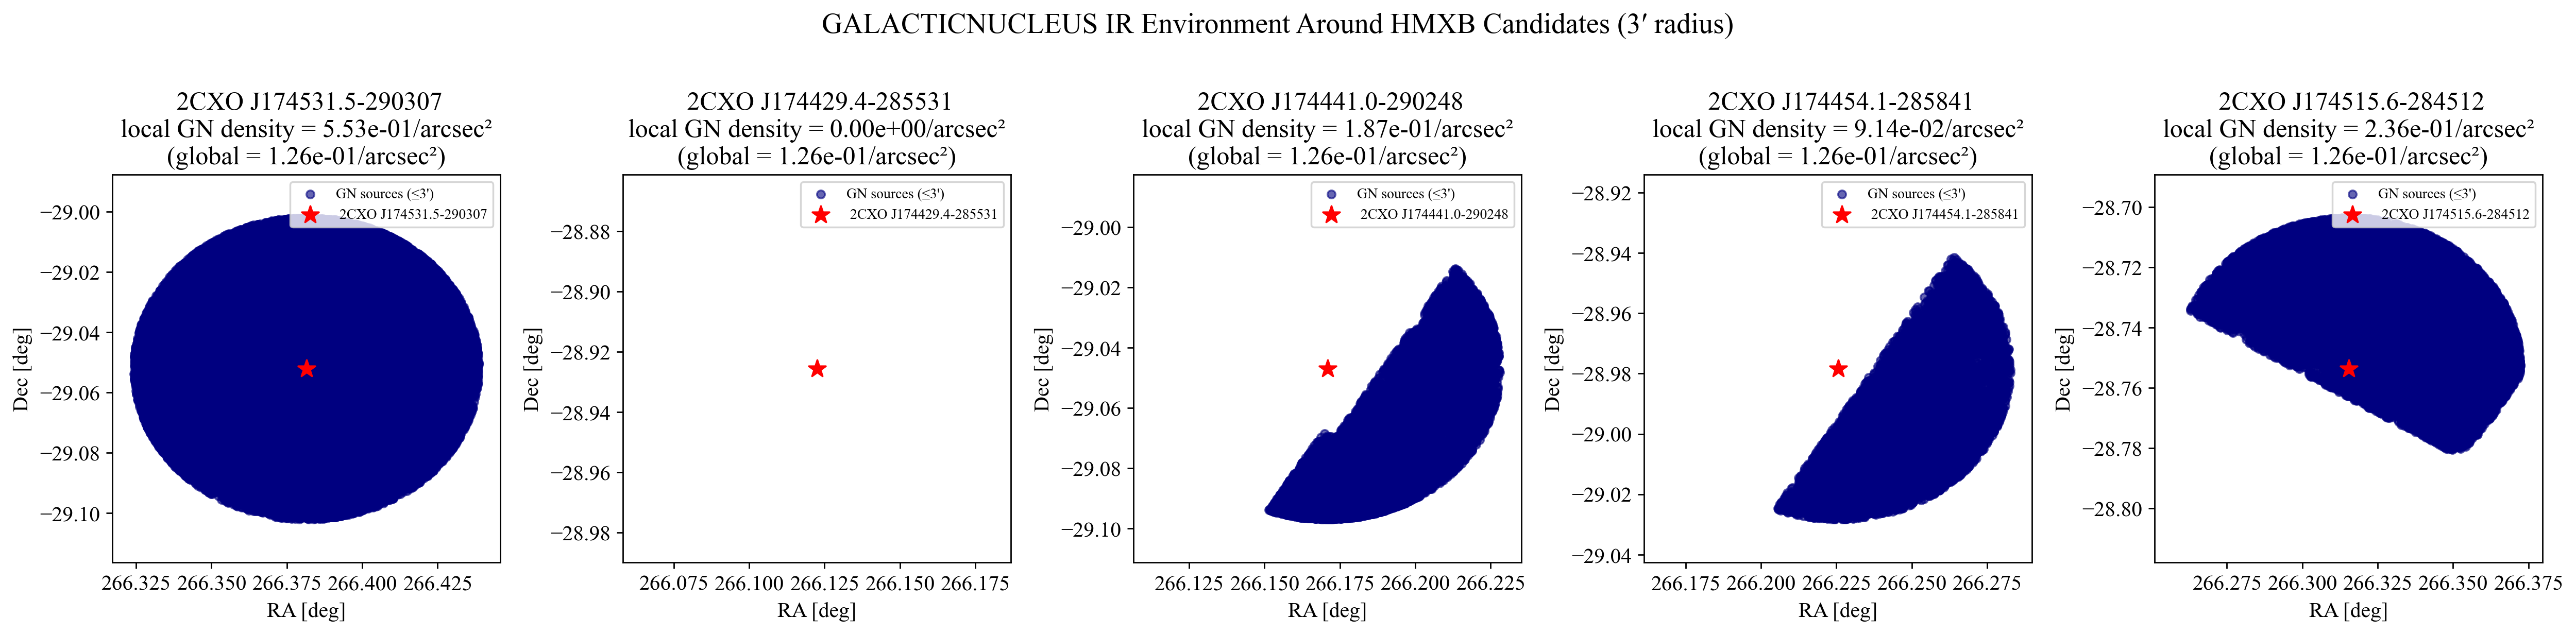

In [139]:
# === IR Density Around HMXB Candidates: GALACTICNUCLEUS ===

# Configuration / constants
GN_RADIUS_ARCSEC = 180.0  # 3 arcminutes
IR_RADIUS = GN_RADIUS_ARCSEC * u.arcsec
area_local_arcsec2 = np.pi * (GN_RADIUS_ARCSEC ** 2)  # area used for local density

# Zoom half-width (in degrees) to give uniform panels
zoom_halfwidth_deg = GN_RADIUS_ARCSEC / 2800.0  # user-tuned value (≈0.064 deg)

# Load / validate candidate and GN data
hmxb_candidates = pd.read_csv("all_hmxb.tsv", sep="\t")  # contains the 5 HMXB candidates

required_cols = ["name", "ra", "dec", "err_ellipse_r0", "err_ellipse_r1", "err_ellipse_ang"]
missing = set(required_cols) - set(hmxb_candidates.columns)
if missing:
    raise ValueError(f"Candidate file missing required columns: {missing}")

gn_df = tbl_gn_clean.copy()
gn_coord = SkyCoord(ra=gn_df["RAJ2000"].to_numpy() * u.deg,
                    dec=gn_df["DEJ2000"].to_numpy() * u.deg)

# Global background GN density (rectangular approximation with cos(dec) correction)
ra_vals = pd.to_numeric(gn_df["RAJ2000"], errors="coerce")
dec_vals = pd.to_numeric(gn_df["DEJ2000"], errors="coerce")
delta_ra = ra_vals.max() - ra_vals.min()
delta_dec = dec_vals.max() - dec_vals.min()
mean_dec_rad = np.deg2rad(dec_vals.mean())
area_deg2 = delta_ra * delta_dec * np.cos(mean_dec_rad)
area_arcsec2_full = area_deg2 * (3600.0 ** 2)
global_density = len(gn_df) / area_arcsec2_full  # per arcsec^2

# Prepare candidate coordinates
cand_coord = SkyCoord(ra=hmxb_candidates["ra"].to_numpy() * u.deg,
                      dec=hmxb_candidates["dec"].to_numpy() * u.deg)

# Panel plot: local GN environment around each HMXB candidate
n_cand = len(hmxb_candidates)
fig, axes = plt.subplots(1, n_cand, figsize=(4 * n_cand, 5), squeeze=False)

for i in range(n_cand):
    ax = axes[0, i]
    row = hmxb_candidates.loc[i]
    name = row["name"]
    ra_i = row["ra"]
    dec_i = row["dec"]

    candidate_coord = cand_coord[i]

    # --- Local GN sources within 3 arcminutes ---
    separations = candidate_coord.separation(gn_coord)  # astropy Angle
    within_mask = separations <= GN_RADIUS
    nearby_gn = gn_df.loc[within_mask]
    n_local = nearby_gn.shape[0]
    local_density = n_local / area_local_arcsec2  # per arcsec^2

    # --- Spatial map ---
    ax.scatter(
        nearby_gn["RAJ2000"], nearby_gn["DEJ2000"],
        s=20, color="navy", alpha=0.6, label="GN sources (≤3')", rasterized=True
    )
    ax.scatter(
        ra_i, dec_i,
        s=100, color="red", marker="*", label=f"{name}", zorder=10
    )

    # Uniform zoom window around each candidate
    ax.set_xlim(ra_i - zoom_halfwidth_deg, ra_i + zoom_halfwidth_deg)
    ax.set_ylim(dec_i - zoom_halfwidth_deg, dec_i + zoom_halfwidth_deg)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("RA [deg]")
    ax.set_ylabel("Dec [deg]")
    ax.set_title(
        f"{name}\n"
        f"local GN density = {local_density:.2e}/arcsec²\n"
        f"(global = {global_density:.2e}/arcsec²)"
    )

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=8, loc="upper right")
    ax.grid(False)

fig.suptitle("GALACTICNUCLEUS IR Environment Around HMXB Candidates (3′ radius)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

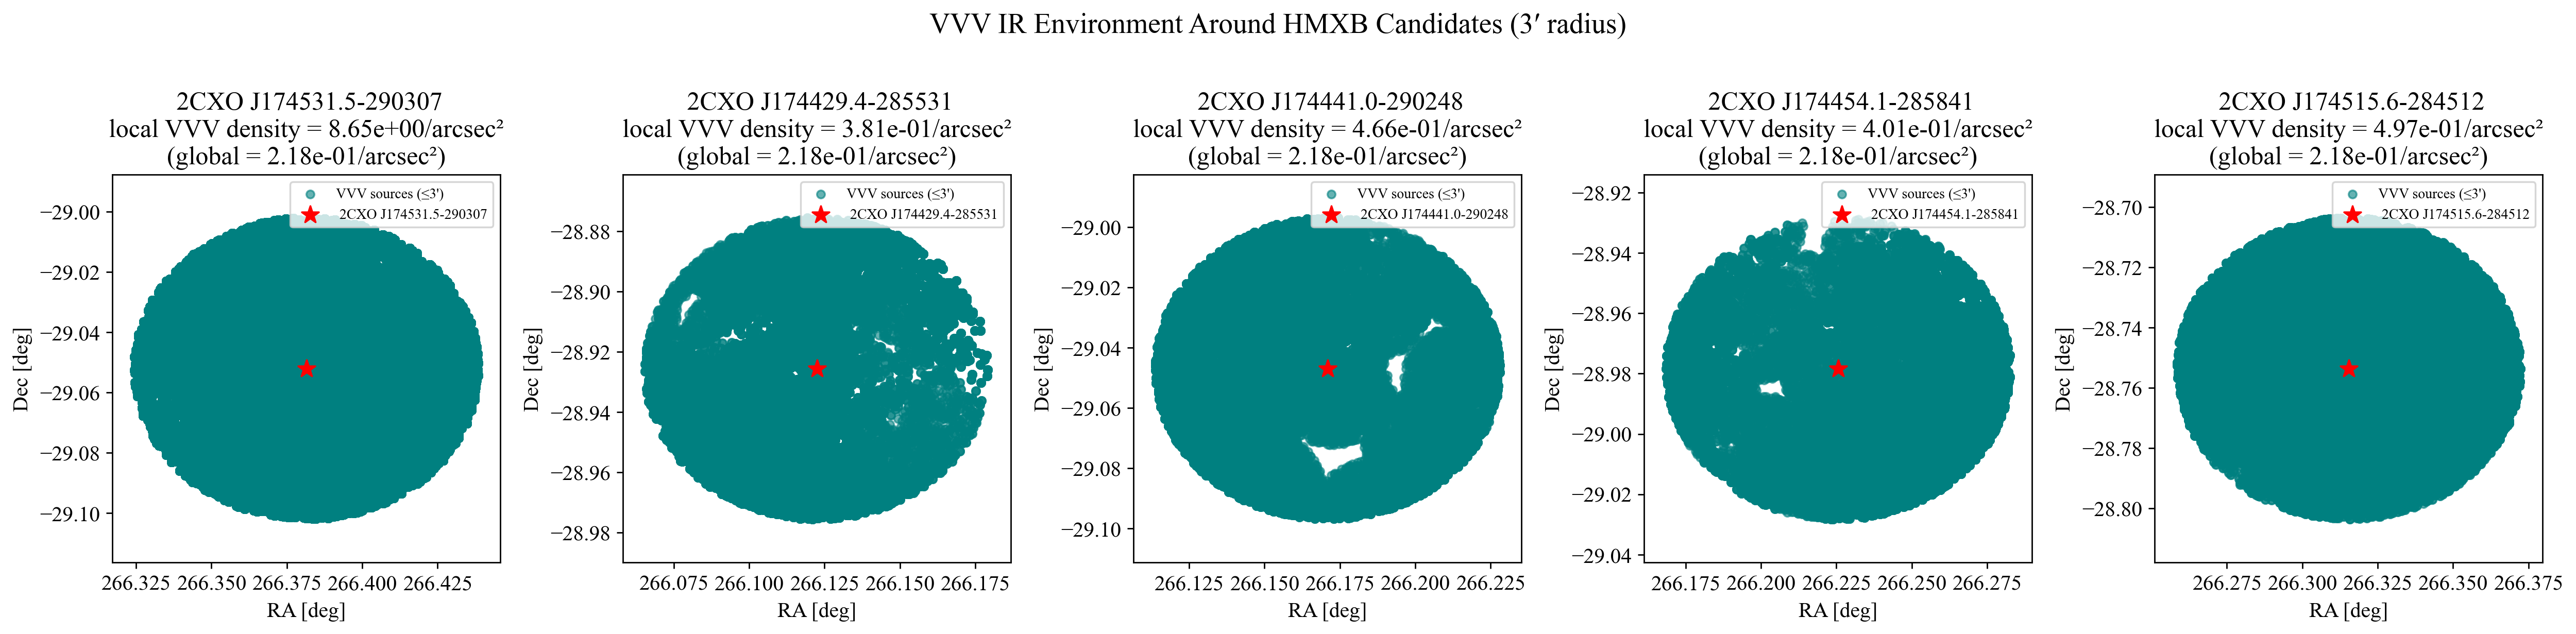

In [140]:
# === IR Density Around HMXB Candidates: VVV ===

# Configuration / constants
VVV_RADIUS_ARCSEC = 180.0  # 3 arcminutes
VVV_RADIUS = VVV_RADIUS_ARCSEC * u.arcsec
LOCAL_AREA_ARCSEC2 = np.pi * (VVV_RADIUS_ARCSEC ** 2)  # area for local density

# Zoom half-width (in degrees) to give uniform panels
zoom_halfwidth_deg = VVV_RADIUS_ARCSEC / 2800.0  # user-tuned

# Prepare VVV catalog SkyCoord
vvv_df = vvv_catalog.copy()
vvv_coord = SkyCoord(ra=vvv_df["RAJ2000"].to_numpy() * u.deg,
                     dec=vvv_df["DEJ2000"].to_numpy() * u.deg)

# Global background density for VVV (rectangular approximation with cos(dec))
def compute_global_density(df):
    ra_vals = pd.to_numeric(df["RAJ2000"], errors="coerce")
    dec_vals = pd.to_numeric(df["DEJ2000"], errors="coerce")
    delta_ra = ra_vals.max() - ra_vals.min()
    delta_dec = dec_vals.max() - dec_vals.min()
    mean_dec_rad = np.deg2rad(dec_vals.mean())
    area_deg2 = delta_ra * delta_dec * np.cos(mean_dec_rad)
    area_arcsec2_full = area_deg2 * (3600.0 ** 2)
    return len(df) / area_arcsec2_full  # per arcsec^2

global_vvv_density = compute_global_density(vvv_df)

# Candidate coordinates
cand_coord = SkyCoord(ra=hmxb_candidates["ra"].to_numpy() * u.deg,
                      dec=hmxb_candidates["dec"].to_numpy() * u.deg)

# Panel plot: VVV IR environment around each HMXB candidate
n_cand = len(hmxb_candidates)
fig, axes = plt.subplots(1, n_cand, figsize=(4 * n_cand, 5), squeeze=False)

for i in range(n_cand):
    ax = axes[0, i]
    row = hmxb_candidates.loc[i]
    name = row["name"]
    ra_i = row["ra"]
    dec_i = row["dec"]

    candidate_coord = cand_coord[i]

    # --- Local VVV sources within 3 arcminutes ---
    separations = candidate_coord.separation(vvv_coord)
    within_mask = separations <= VVV_RADIUS
    nearby_vvv = vvv_df.loc[within_mask]
    n_local = nearby_vvv.shape[0]
    local_density = n_local / LOCAL_AREA_ARCSEC2  # per arcsec^2

    # --- Spatial map ---
    ax.scatter(
        nearby_vvv["RAJ2000"], nearby_vvv["DEJ2000"],
        s=20, color="teal", alpha=0.6, label="VVV sources (≤3')", rasterized=True
    )
    ax.scatter(
        ra_i, dec_i,
        s=100, color="red", marker="*", label=f"{name}", zorder=10
    )

    # Uniform zoom window around each candidate
    ax.set_xlim(ra_i - zoom_halfwidth_deg, ra_i + zoom_halfwidth_deg)
    ax.set_ylim(dec_i - zoom_halfwidth_deg, dec_i + zoom_halfwidth_deg)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("RA [deg]")
    ax.set_ylabel("Dec [deg]")
    ax.set_title(
        f"{name}\n"
        f"local VVV density = {local_density:.2e}/arcsec²\n"
        f"(global = {global_vvv_density:.2e}/arcsec²)"
    )

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=8, loc="upper right")
    ax.grid(False)

fig.suptitle("VVV IR Environment Around HMXB Candidates (3′ radius)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 3. HMXB candidates and error ellipse with IR Counterparts

Detailed zoomed-in views for each of the five HMXB candidates, plotting the candidate position, its positional uncertainty (error ellipse or marker), and nearby infrared sources from the relevant catalog (GALACTICNUCLEUS and/or VVV).

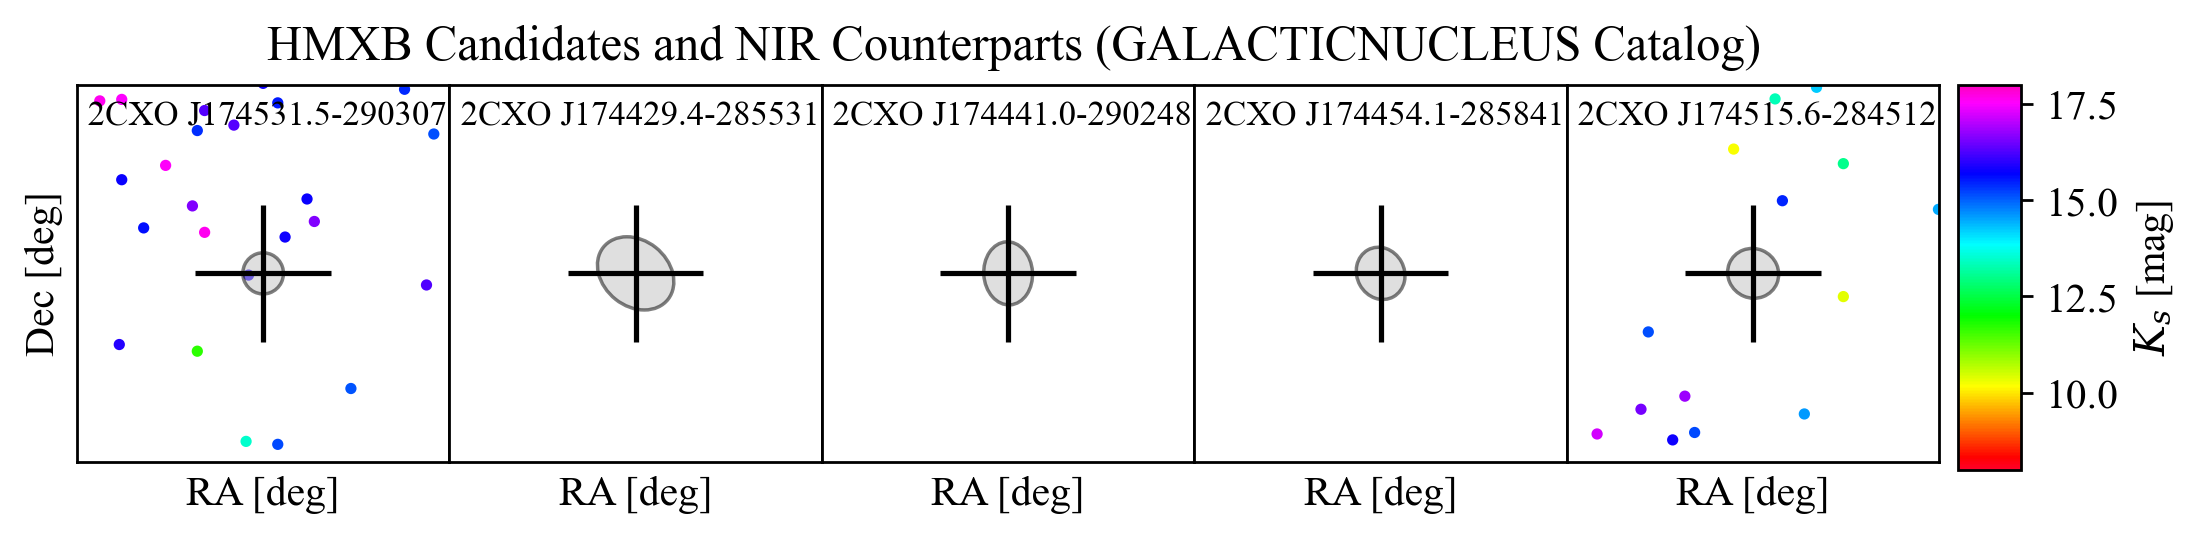

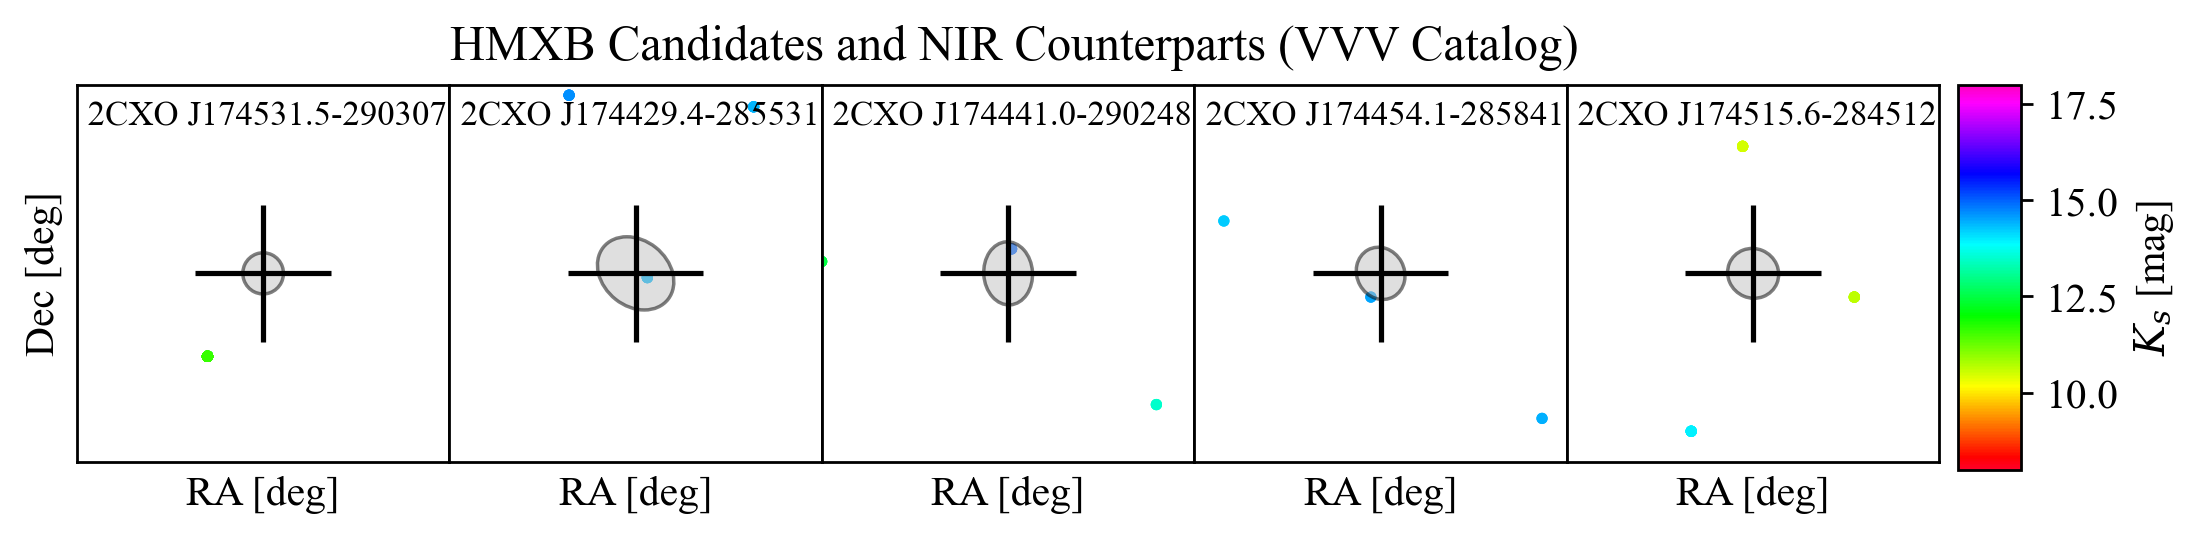

In [136]:
# === HMXB Candidates with IR Counterparts ===

def plot_hmxb_with_nir(
    hmxb_candidates,
    ir_catalog,
    ir_label,
    k_column="Ksmag",
    ra_col="RAJ2000",
    dec_col="DEJ2000",
    xr_unc_arcsec=XR_UNC_ARCSEC,
    kmin=KMIN,
    kmax=KMAX,
):
    """
    Plot the HMXB candidates with nearby NIR sources from a given catalog.
    Parameters:
        hmxb_candidates: DataFrame with the 5 candidates (must have 'ra','dec','err_ellipse_r0', etc.)
        ir_catalog: DataFrame of the infrared catalog (GN or VVV)
        ir_label: string for title (e.g., "GALACTICNUCLEUS" or "VVV")
        k_column: name of the Ks magnitude column in ir_catalog
        ra_col, dec_col: coordinate column names in ir_catalog
    """
    # Validate magnitude column
    if k_column not in ir_catalog.columns:
        raise KeyError(f"Infrared catalog for {ir_label} missing magnitude column '{k_column}'")

    # Extract candidate info
    hmxb_ra = hmxb_candidates["ra"].to_numpy()
    hmxb_dec = hmxb_candidates["dec"].to_numpy()
    epos = hmxb_candidates["err_ellipse_r0"].to_numpy()
    epos2 = hmxb_candidates["err_ellipse_r1"].to_numpy()
    posang = hmxb_candidates["err_ellipse_ang"].to_numpy()
    names = hmxb_candidates["name"].to_numpy()

    # Infrared catalog arrays
    ir_K = np.array(ir_catalog[k_column])
    ir_ra = np.array(ir_catalog[ra_col])
    ir_dec = np.array(ir_catalog[dec_col])

    # Setup figure
    fig = plt.figure(figsize=(10, 2))
    for i in range(NUM_CAND):
        ax = fig.add_subplot(1, NUM_CAND, i + 1)

        # Filter: Ks < KMAX and narrow RA slice
        dra = np.abs(hmxb_ra[i] - ir_ra)
        mask_mag = ir_K < kmax
        mask_ra = dra < (10.0 / 3600.0)
        Kfilt_idx = np.where(mask_mag & mask_ra)[0]

        # Plot IR sources colored by magnitude
        im = ax.scatter(
            ir_ra[Kfilt_idx],
            ir_dec[Kfilt_idx],
            c=ir_K[Kfilt_idx],
            cmap="gist_rainbow",
            vmin=kmin,
            vmax=kmax,
            s=5,
            zorder=1,
        )

        # Error ellipse
        ellipse = Ellipse(
            (hmxb_ra[i], hmxb_dec[i]),
            width=2 * epos2[i] / 3600.0,
            height=2 * epos[i] / 3600.0,
            angle=-posang[i],
            facecolor="silver",
            edgecolor="k",
            alpha=0.5,
            zorder=2,
        )
        ax.add_patch(ellipse)

        # X-ray crosshair with uncertainty
        unc_deg = xr_unc_arcsec / 3600.0
        ax.errorbar(
            hmxb_ra[i],
            hmxb_dec[i],
            xerr=unc_deg,
            yerr=unc_deg,
            fmt="o",
            ms=1,
            c="k",
            zorder=3,
        )

        # Axis formatting
        ax.set_xlim(hmxb_ra[i] - ZOOM_ARCSEC / 3600.0, hmxb_ra[i] + ZOOM_ARCSEC / 3600.0)
        ax.set_ylim(hmxb_dec[i] - ZOOM_ARCSEC / 3600.0, hmxb_dec[i] + ZOOM_ARCSEC / 3600.0)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_ylabel("Dec [deg]")
        ax.set_xlabel("RA [deg]")
        ax.text(
            hmxb_ra[i],
            hmxb_dec[i] + 0.0006,
            names[i],
            fontsize=10,
            ha="center",
            color="black",
            zorder=4,
        )
        ax.label_outer()

    # Colorbar
    fig.subplots_adjust(right=0.87)
    cbar_ax = fig.add_axes([0.8775, 0.11, 0.025, 0.77])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(r"$K_s$ [mag]")

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(f"HMXB Candidates and NIR Counterparts ({ir_label} Catalog)", x=0.5, y=1.0, ha="center", fontsize=14)
    plt.show()


# Calls for each catalog
plot_hmxb_with_nir(hmxb_candidates, gn_catalog, ir_label="GALACTICNUCLEUS", k_column="Ksmag")
plot_hmxb_with_nir(hmxb_candidates, vvv_catalog, ir_label="VVV", k_column="Ksmag3")